#  <span style="color:royalblue">Проект обучение с учителем: качество модели

<div style="background-color: white; border: 3px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

## Описание проекта 
    
---

**Заказчик:** Руководство интернет-магазина «В один клик».
    
**Цель:** Разработать решение для персонализации предложений постоянным клиентам с целью увеличения их покупательской активности.

**Задачи:**
    
**1.** Промаркировать уровень финансовой активности постоянных покупателей (снизилась / прежний уровень).

**2.** Собрать и подготовить данные по клиентам, сгруппированные по признакам:

- Коммуникация с клиентом;

- Продуктовое поведение;

- Покупательское (финансовое) поведение;

- Поведение на сайте.

**3.** Построить прогнозную модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

**4.** Проанализировать данные о прибыльности клиентов за последние три месяца.

**5.** На основе прогнозов модели и данных о прибыльности выделить сегменты покупателей.

**6.** Разработать персонализированные предложения для каждого выделенного сегмента.
 
---    
    
**Описание данных:**
    
<span style="color:cornflowerblue"> **1.** Таблица  `market_file` [содержит информацию **о поведении покупателя на сайте/о коммуникациях с покупателем/о продуктовом поведении**]

- `id` — номер покупателя.
- `Покупательская активность` — рассчитанный класс покупательской активности(снизилась/прежний уровень).
- `Тип сервиса` — уровень сервиса (премиум/стандарт).
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта за последние 3 месяца.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
    
    
<span style="color:cornflowerblue"> **2.** Таблица  `market_money` [содержит информацию **о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом**]

- `id` — номер покупателя.
- `Период` — название периода, во время которого зафиксирована выручка(текущий_месяц/предыдущий_месяц).
- `Выручка` — сумма выручки за период в условных единицах.
    
<span style="color:cornflowerblue"> **3.** Таблица  `market_time` [содержит информацию **о Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода**]

- `id` — номер покупателя.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

<span style="color:cornflowerblue"> **4.** Таблица  `money` [содержит информацию **о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю**]

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли в условных единицах.


## Шаг 1. Загрузка данных

---

In [1]:
!pip install -q scikit-learn
!pip install -q shap
# Необходимые импорты
import pandas as pd

import requests
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler)
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем функции для графика ROC-кривой и расчёта ROC-AUC
from sklearn.metrics import roc_auc_score, RocCurveDisplay


# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: C:\Users\dns\AppData\Local\Python\pythoncore-3.14-64\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: C:\Users\dns\AppData\Local\Python\pythoncore-3.14-64\python.exe -m pip install --upgrade pip


#### <span style="color:royalblue"> Функция. Импорт Google-таблицы

In [2]:
def import_google_sheet(spreadsheet_id, sheet_name=None):
    '''
    Импортирем Google-таблицу в pandas DataFrame
    Параметры:
    spreadsheet_id (str): ID Google таблицы (из URL)
    sheet_name (str, optional): Название листа. Если None, импортирует первый лист
    '''
    
    # Формируем URL для экспорта
    if sheet_name:
        file_name = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    else:
        file_name = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv'
    
    # Загружаем данные
    r = requests.get(file_name)
    r.raise_for_status()  # Проверяем успешность запроса
    
    # Читаем в DataFrame
    df = pd.read_csv(BytesIO(r.content))
    
    return df

In [3]:
# Импортируем Google-таблицы с данными и сохраненим в датафреймы
market_file = import_google_sheet(spreadsheet_id='1RyINCCvEqfvREQRPb0H31R3qhr4mAxjY5VxYe1YOxTI')
market_money = import_google_sheet(spreadsheet_id='1fgBVfdehD2tVtJf7jLd6E8vHUk6j-MLB-4eFg2A_Vpw')
market_time = import_google_sheet(spreadsheet_id='1XLWaXdoyPc-xfZ-X9QjEsZ55qaSdB6mcQThtIhaBejs')
money = import_google_sheet(spreadsheet_id='1Ik8WDDKM-cNdLC6Ws8zFI1meUO7AFETGCJVn6mCH3wY')

#### <span style="color:royalblue">Функция. Общая информация и Первые строки

In [4]:
def head_and_info_display(df, n=5, show_shape=True, show_dtypes=True):
    '''
    Параметры:
    df - DataFrame для анализа
    n - Количество строк
    '''
    print('~' * 23)
    print('ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ')
    print('~' * 23)
   
    print(f'Форма данных: {df.shape[0]} строк, {df.shape[1]} столбцов')
    
    print(f"\nПервые {n} строк:")
    print("-" * 15)
    display(df.head(n))
    
    print(f"\nОбщая информация:")
    print("-" * 17)
    df.info()

In [5]:
# Создадим словарь для удобства замены названий колонок на соответствующие допустимому стилю
rename_columns = {
                    'Покупательская активность': 'purchase_activity',
                    'Тип сервиса': 'service_type',
                    'Разрешить сообщать': 'allow_notifications',
                    'Маркет_актив_6_мес': 'marketing_activity_6_months',
                    'Маркет_актив_тек_мес': 'marketing_activity_current_month',
                    'Длительность': 'duration',
                    'Акционные_покупки': 'promotional_purchases',
                    'Популярная_категория': 'popular_category',
                    'Средний_просмотр_категорий_за_визит': 'avg_categories_per_visit',
                    'Неоплаченные_продукты_штук_квартал': 'unpaid_products_quarter',
                    'Ошибка_сервиса': 'service_error',
                    'Страниц_за_визит': 'pages_per_visit',
                    'Период': 'period',
                    'Выручка': 'revenue',
                    'минут': 'minutes',
                    'Прибыль': 'profit',
                  }
# Переименовываем столбцы
market_file.rename(columns=rename_columns, inplace=True)
market_money.rename(columns=rename_columns, inplace=True)
market_time.rename(columns=rename_columns, inplace=True)
money.rename(columns=rename_columns, inplace=True)

### Таблица `market_file`

In [6]:
head_and_info_display(market_file)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 1300 строк, 13 столбцов

Первые 5 строк:
---------------


,id,purchase_activity,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,avg_categories_per_visit,unpaid_products_quarter,service_error,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1300 non-null   int64  
 1   purchase_activity                 1300 non-null   object 
 2   service_type                      1300 non-null   object 
 3   allow_notifications               1300 non-null   object 
 4   marketing_activity_6_months       1300 non-null   float64
 5   marketing_activity_current_month  1300 non-null   int64  
 6   duration                          1300 non-null   int64  
 7   promotional_purchases             1300 non-null   float64
 8   popular_category                  1300 non-null   object 
 9   avg_categories_per_visit          1300 non-null   int64  
 10  unpaid_products_quarter           1300 non-null   int64  
 11  service_error                   

<div style="background-color: white; border: 1.5px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
- В таблице `market_file` 1300 записей и 13 столбцов. Нет пропусков в данных, типы данных верные.
- Видим неявные дубликаты в столбце `service_type`
- Ошибка в столбце `popular_category` в значении 'Косметика и аксесуары' заменим на 'Косметика и аксессуары'
- Приведем к нижнему регистру значения в столбцах `purchase_activity` и `popular_category`

### Таблица `market_money`

In [7]:
head_and_info_display(market_money)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 3900 строк, 3 столбцов

Первые 5 строк:
---------------


,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


<div style="background-color: white; border: 1.5px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
- В таблице `market_money` 3900 записей и 3 столбца. Нет пропусков в данных, типы данных верные.
- Уберем нижние подчеркивания в значениях столбца 'period'

### Таблица `market_time`

In [8]:
head_and_info_display(market_time)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 2600 строк, 3 столбцов

Первые 5 строк:
---------------


,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


<div style="background-color: white; border: 1.5px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
- В таблице `market_time` 2600 записей и 3 столбца. Нет пропусков в данных, типы данных верные.
- Видим в столбце `period` неверное значение - заменим 'предыд**ц**щий_месяц' на 'предыд**у**щий_месяц'.

### Таблица `money`

In [9]:
head_and_info_display(money)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 1300 строк, 2 столбцов

Первые 5 строк:
---------------


,id,profit
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1300 non-null   int64 
 1   profit  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


<div style="background-color: white; border: 1.5px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
- В таблице `money` 1300 записей и 2 столбца. Нет пропусков в данных, типы данных верные.
- Заменим тип данных на float +Дробные значения записаны через запятую - поправим.

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод

<span style="color:cornflowerblue"> В ДАННОМ РАЗДЕЛЕ МЫ ЗНАКОМИЛИСЬ С ДАННЫМИ И ПРИВОДИЛИ ИХ В ПРИСТОЙНЫЙ ВИД.

---    
    
<span style="color:cornflowerblue"> **1.** Изменили названия столбцов, приведя их к единому стилю:
    
- `Покупательская активность` на **`purchase_activity`**,
- `Тип сервиса` на **`service_type`**,
- `Разрешить сообщать` на **`allow_notifications`**,
- `Маркет_актив_6_мес` на **`marketing_activity_6_months`**,
- `Маркет_актив_тек_мес` на **`marketing_activity_current_month`**,
- `Длительность` на **`duration`**,
- `Акционные_покупки` на **`promotional_purchases`**,
- `Популярная_категория` на **`popular_category`**,
- `Средний_просмотр_категорий_за_визит` на **`avg_categories_per_visit`**,
- `Неоплаченные_продукты_штук_квартал` на **`unpaid_products_quarter`**,
- `Ошибка_сервиса` на **`service_error`**,
- `Страниц_за_визит` на **`pages_per_visit`**,
- `Период` на **`period`**,
- `Выручка` на **`revenue`**,
- `минут` на **`minutes`**,
- `Прибыль` на **`profit`**,
    
<span style="color:cornflowerblue"> **2.** Создали функцию для оперативного и симпатичного вывода общей информации и датафреймах
    
- В таблице `market_file` 1300 записей и 13 столбцов.
- В таблице `market_money` 3900 записей и 3 столбца.
- В таблице `market_time` 2600 записей и 3 столбца.
- В таблице `money` 1300 записей и 2 столбца
    
<span style="color:cornflowerblue"> **3.** Выявили в таблицах:


- Неявные дубликаты

    - В таблице `market_file` в столбце 'service_type' [заменим 'стандарт**т**' на 'стандарт']


- Некорректные значения

    - В таблице `market_time` в столбце 'period' неверное значение [заменим 'предыд**ц**щий_месяц' на 'предыдущий_месяц']
    - В таблице `money` в столбце  'profit' [дробные значения записаны через запятую - поправим]
    - В таблице `market_file` ошибка в столбце 'popular_category' [заменим 'Косметика и аксесуары' на 'Косметика и аксессуары']

<span style="color:cornflowerblue"> **4.** Приведем данные к стандартному виду:

- В таблице `market_file`

    - Приведем к нижнему регистру значения в столбцах `purchase_activity` и `popular_category`.

- В таблице `market_money`

    - Уберем нижние подчеркивание между словами в столбце `period`.

- В таблице `market_time`

    - Уберем нижние подчеркивание между словами в столбце `period`.

    
В данных нет пропусков, все колонки нужных типов данных кроме столбца profit таблицы `money` - заменим.

    
---
    
<span style="color:cornflowerblue">ДАЛЕЕ ПРОВЕДЁМ ПРЕДОРАБОТКУ ДАННЫХ: 

- Заменим неявные дубликаты и некорректные значения,
- Приведем к единому стилю [строчные буквы без нижнего подчеркивания между слов]
- Заменим тип данных в столбце 'profit' таблицы `money`
- Проверим данные на дубликаты.


## Шаг 2. Предоработка данных

---

### Работа с неявными дубликатами

In [10]:
def show_unique_simple(**tables):
    ''' Для вывода уникальных значений таблиц с категориальными столбцами'''
    for name, df in tables.items():
        print(f'\n--- {name} ---')
        for col in df.select_dtypes(include=['object']).columns:
            print(f'{col}: {list(df[col].unique())}')

In [11]:
# Выявляем
show_unique_simple(market_file=market_file, market_time=market_time, market_money=market_money)
print(f'\n--- money ---')
display(money.head(2))


--- market_file ---
purchase_activity: ['Снизилась', 'Прежний уровень']
service_type: ['премиум', 'стандартт', 'стандарт']
allow_notifications: ['да', 'нет']
popular_category: ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']

--- market_time ---
period: ['текущий_месяц', 'предыдцщий_месяц']

--- market_money ---
period: ['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц']

--- money ---


,id,profit
0,215348,"0,98"
1,215349,"4,16"


In [12]:
# 1. Приведем значения к нижнему регистру и уберем нижнее подчеркивание
market_file['purchase_activity'] = market_file['purchase_activity'].str.lower()

market_file['popular_category'] = (market_file['popular_category']
                                                                   .str.lower()
                                                                   .str.replace('косметика и аксесуары', 'косметика и аксесcуары')#заодно поправим ошибку
                                  )
market_money['period'] = market_money['period'].str.replace('_', ' ')
market_time['period'] = market_time['period'].str.replace('_', ' ')

# 2. Заменим неявные дубликаты
market_file['service_type'] = market_file['service_type'].str.replace('стандартт', 'стандарт')
# 3. Заменяем некорректные значения
market_time['period'] = market_time['period'].str.replace('предыдцщий месяц', 'предыдущий месяц')
money['profit'] = (money['profit']
                                   .str.replace(',', '.')
                                   .astype('float')
                  )

In [13]:
# Проверочка
show_unique_simple(market_file=market_file, market_time=market_time, market_money=market_money)
print(f'\n--- money ---')
display(money.head(2))
display(money['profit'].dtype)


--- market_file ---
purchase_activity: ['снизилась', 'прежний уровень']
service_type: ['премиум', 'стандарт']
allow_notifications: ['да', 'нет']
popular_category: ['товары для детей', 'домашний текстиль', 'косметика и аксесcуары', 'техника для красоты и здоровья', 'кухонная посуда', 'мелкая бытовая техника и электроника']

--- market_time ---
period: ['текущий месяц', 'предыдущий месяц']

--- market_money ---
period: ['препредыдущий месяц', 'текущий месяц', 'предыдущий месяц']

--- money ---


,id,profit
0,215348,0.98
1,215349,4.16


dtype('float64')

### Работа с явными дубликатами

#### <span style="color:royalblue"> Функция. Кол-во дубликатов для всех таблиц

In [14]:
def cnt_duplicates(**tables):
    '''Отображает кол-во дублей для нескольких таблиц'''    
    for name, df in tables.items():
        duplicates = df.duplicated().sum()
        print(f'{name}: Кол-во дублей: {duplicates}')

In [15]:
cnt_duplicates(market_file=market_file, market_money=market_money, market_time=market_time, money=money)

market_file: Кол-во дублей: 0
market_money: Кол-во дублей: 0
market_time: Кол-во дублей: 0
money: Кол-во дублей: 0


<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод

<span style="color:cornflowerblue"> В ДАННОМ РАЗДЕЛЕ МЫ ПРОВЕЛИ ПЕРВИЧНЫЕ АНАЛИЗ И ПОЗНАКОМИЛИСЬ С ДАННЫМИ ПОБЛИЖЕ.

---

<span style="color:cornflowerblue"> *В таблице `market_file`* явных дубликатов не обнаружено.

- Заменили неявные дубликаты в столбце `service_type`.
- Исправили орфографическую ошибку в столбце `popular_category`.
- Привели к нижнему регистру значения в столбце `purchase_activity` и `popular_category`.

---
    
<span style="color:cornflowerblue"> *В таблице `market_money`* явных дубликатов не обнаружено.

- Убрали нижнее подчеркивание в значениях столбца `period`.
    
---

<span style="color:cornflowerblue"> *В таблице `market_time`* явных дубликатов не обнаружено.

- убрали нижнее подчеркивание и заменили некорректные значения в столбце `period`

---
    
<span style="color:cornflowerblue"> *В таблице `money`* явных дубликатов не обнаружено.
    
- Заменили запятую на точку в дробных значениях в столбце `profit`
- Заменили тип данных на float в столбце `profit`

    
---
    
<span style="color:cornflowerblue"> ДАЛЕЕ ПРИСТУПИМ К ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ ДАННЫХ

- Разделим данные на колличесвенные и качественные, посмотрим на распределения значений в данных, построив графики для каждого признака.
    
    - Для количественных признаков мы построим: "Ящик с усами" и Гистограмму.
    - Для категориальных признаков мы построим: Столбчатую и круговую диаграммы.

## Шаг 3. Исследовательский анализ данных

---

#### <span style="color:royalblue">Функция. Столбчатая и Круговая диаграммы

In [16]:
# Функция для быстрого отображения категориальных признаков с двумя графиками и симпатичной цветовой палитрой
def plot_categorical(df, column, figsize=(15, 8), palette='Paired'):
    
    '''Столбчатая и круговая диаграмма'''
    
    # Подсчитываем кол-во уникальных значений
    value_counts = df[column].value_counts()
    
    # Создаем две диаграммы
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, # 1 ряд, 2 графика в ряд
                                   figsize=figsize)
    # fig управляет всей областью отрисовки
    # ax1 - левый график (первый столбец)
    # ax2 - правый график (второй столбец)  
    
    # 1. Столбчатая диаграмма
    sns.countplot(data=df, # Указываем, откуда брать данные для построения графика
                  x=column, # Указываем, какой столбец использовать для оси X
                  hue=column,  # Раскрашиваем столбцы по тому же столбцу
                  legend=False,  # Отключаем  дублирующую легенду
                  palette=palette, # Задаем цветовую схему для столбцов
                  ax=ax1 # Указываем, в какой области рисовать график
                  )
    ax1.set_title(f'Распределение по {column}', fontsize=14)
    ax1.set_xlabel(column) #Подпись дляя оси х на графике ах1
    ax1.set_ylabel('Кол-во')
    # Поворачиваем подписи и выравниваем вправо
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Добавляем числа на столбцы
    for p in ax1.patches: # Цикл по каждому столбцу на графике
        ax1.annotate(f'{p.get_height()}', #добавляем текстовую аннотацию на график
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center',# Горизонтальное выравнивание по центру
                    va='bottom', # Вертикальное выравнивание по низу (текст над столбцом)
                    fontweight='bold')
    #p.get_x() - координата X левого края столбца
    #get_width()/2 - половина ширины столбца
    #p.get_height() - координата Y верхнего края столбца
    
    # 2. Круговая диаграмма
    colors = sns.color_palette(palette, 
                               len(value_counts)#количество цветов (по числу категорий)
                               )
    ax2.pie(value_counts.values,#кол-во
            labels=value_counts.index,#название категорий 
            autopct='%1.1f%%', #отображение процентов
            colors=colors, #цвета секторов
            startangle=90) #начальный угол
    ax2.set_title(f'Доли категорий {column}', 
                  fontsize=14)
    
    print(f"Статистика для '{column}':")
    print(f"Всего записей: {len(df)}")
    print(f"Уникальных категорий: {df[column].nunique()}")
    print(f"Самая частая категория: '{value_counts.index[0]}' ({value_counts.iloc[0]} записей)")
    print(f"Доля самой частой категории: {value_counts.iloc[0]/len(df)*100:.1f}%")

### 3.1 Статистика и графики распределений для категориальных значений

---

<span style="color:cornflowerblue"> **ТАБЛИЦА: `market_file`**

<span style="color:cornflowerblue"> СТОЛБЦЫ:

- **purchase_activity** `[Покупательская активность]`
- **service_type** `[Тип сервиса]`
- **allow_notifications** `[Разрешить сообщать]`
- **popular_category** `[Популярная категория]`
- **avg_categories_per_visit** `[Средний просмотр категорий за визит]`
- **marketing_activity_current_month** `[Маркетинговая активность в текущем месяце]`
- **unpaid_products_quarter** `[Неоплаченные продукты штук квартал]`
- **service_error**  `[Ошибка сервиса]`
  
---

#### purchase_activity `[Покупательская активность]`

Статистика для 'purchase_activity':
Всего записей: 1300
Уникальных категорий: 2
Самая частая категория: 'прежний уровень' (802 записей)
Доля самой частой категории: 61.7%


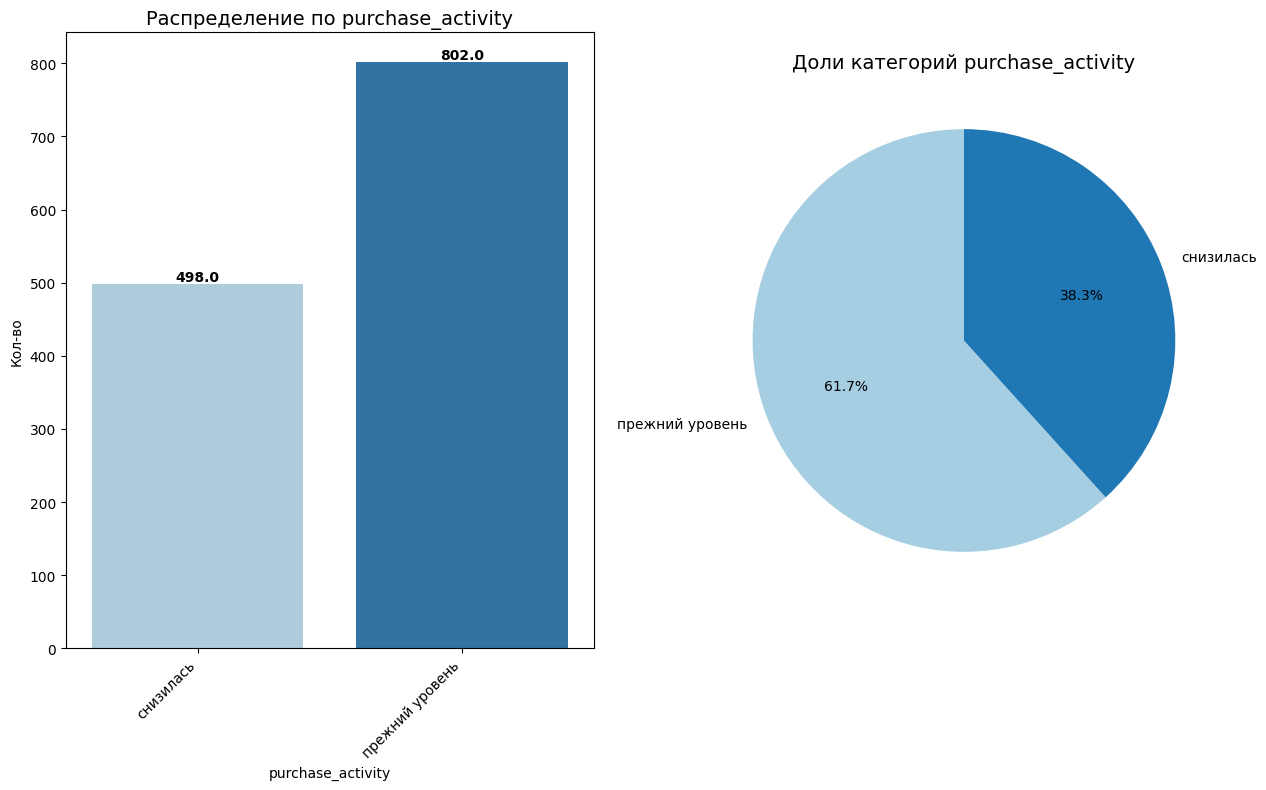

In [17]:
# Столбец 'purchase_activity' [Покупательская актвность]
plot_categorical(market_file, column='purchase_activity')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику распределения категории `покупательская активность` видим, что самая частая категория - это `прежний уровень` (802 записи, доля 61.7%)

- 61.7% клиентов сохранили прежний уровень активности (802 записи)
- 38.3% клиентов снизили активность (498 записей)

Наблюдается умеренный дисбаланс в целевом признаке. Он не сильный, но требует внимания при выборе метрики и интерпретации модели.
Поэтому мы уже можем отметить, что для бинарной классификации при дисбалансе (даже умеренном) лучше использовать ROC-AUC. Так как она устойчива к дисбалансу.

Несмотря на преобладание стабильных клиентов, значительная доля (каждый третий) показывает снижение активности, что указывает на необходимость срочных мер по удержанию.

#### service_type `[Тип сервиса]`

Статистика для 'service_type':
Всего записей: 1300
Уникальных категорий: 2
Самая частая категория: 'стандарт' (924 записей)
Доля самой частой категории: 71.1%


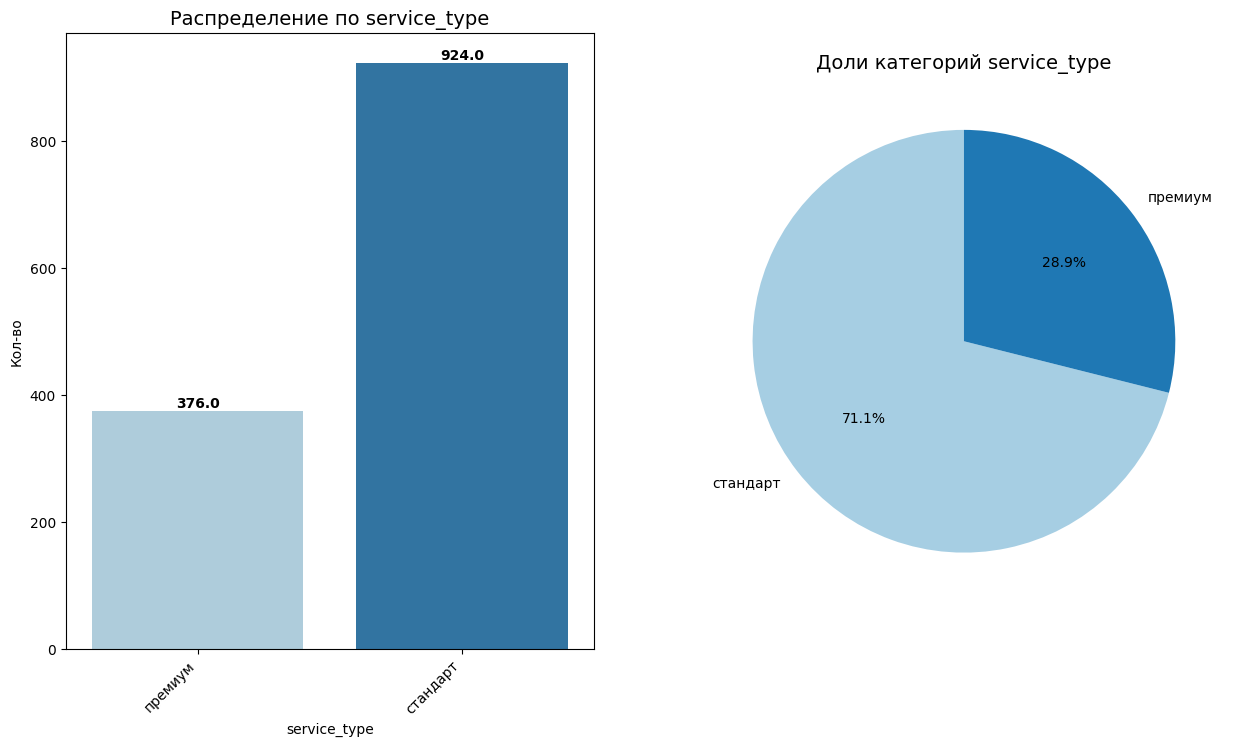

In [18]:
# Столбец 'service_type' [Тип сервиса]
plot_categorical(market_file, column='service_type')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику распределения категории `тип сервиса` видим, что самая частая категория - это `стандарт` (924 записи, доля 71.1%)

- 71.1% клиентов используют стандартный сервис (924 записи)
- 28.9% клиентов используют премиум-сервис (376 записей)

База клиентов состоит преимущественно из пользователей стандартного тарифа, при этом премиум-сегмент составляет значительную долю (~29%), что свидетельствует о потенциале для монетизации (премиум-сегмент достаточно велик для запуска программ лояльности и дополнительных платных опций)

#### allow_notifications `[Разрешить сообщать]`

Статистика для 'allow_notifications':
Всего записей: 1300
Уникальных категорий: 2
Самая частая категория: 'да' (962 записей)
Доля самой частой категории: 74.0%


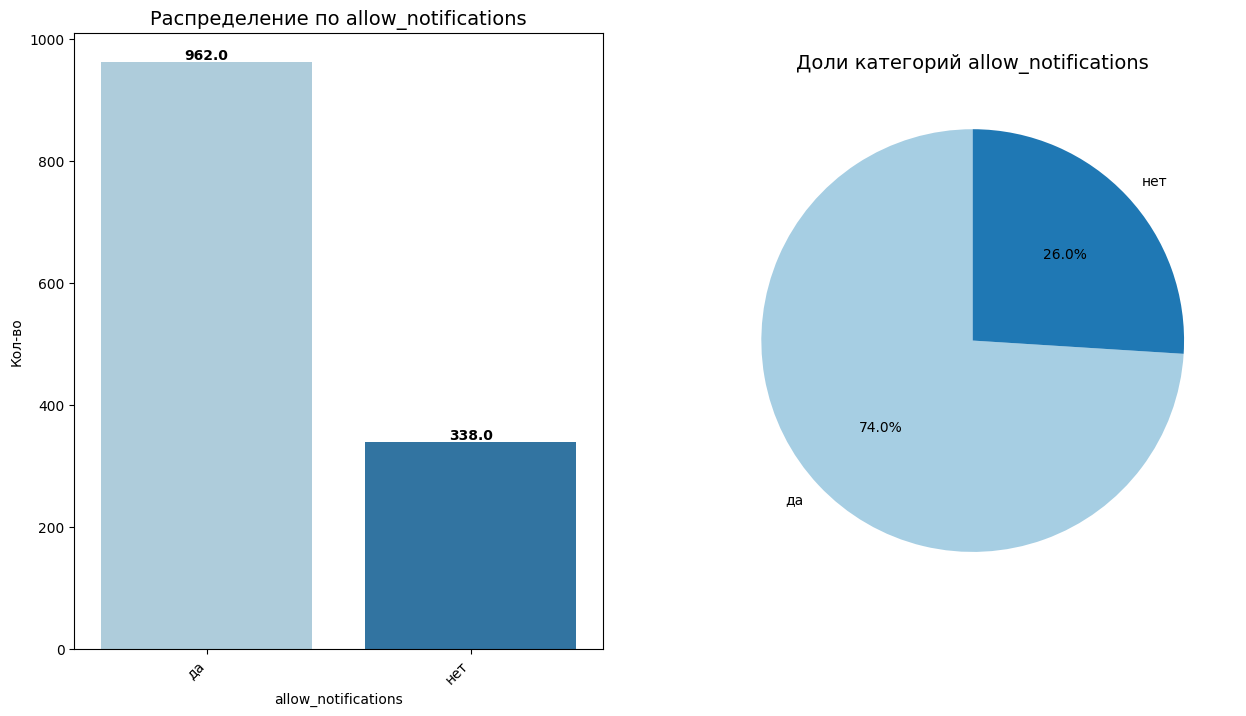

In [19]:
# Столбец 'allow_notifications' [Разрешить сообщать]
plot_categorical(market_file, column='allow_notifications')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику распределения категории `Разрешить сообщать` видим, что самая частая категория - это `да` (962 записи, доля 74%).

- 74% клиентов согласны на получение сообщений (962 пользователя)
- 26% клиентов отказались от коммуникации (338 пользователей)

Большинство клиентов лояльно к дополнительным коммуникациям, что открывает значительные возможности для персонализированной маркетинговой активности.

#### popular_category `[Популярная категория]`

Статистика для 'popular_category':
Всего записей: 1300
Уникальных категорий: 6
Самая частая категория: 'товары для детей' (330 записей)
Доля самой частой категории: 25.4%


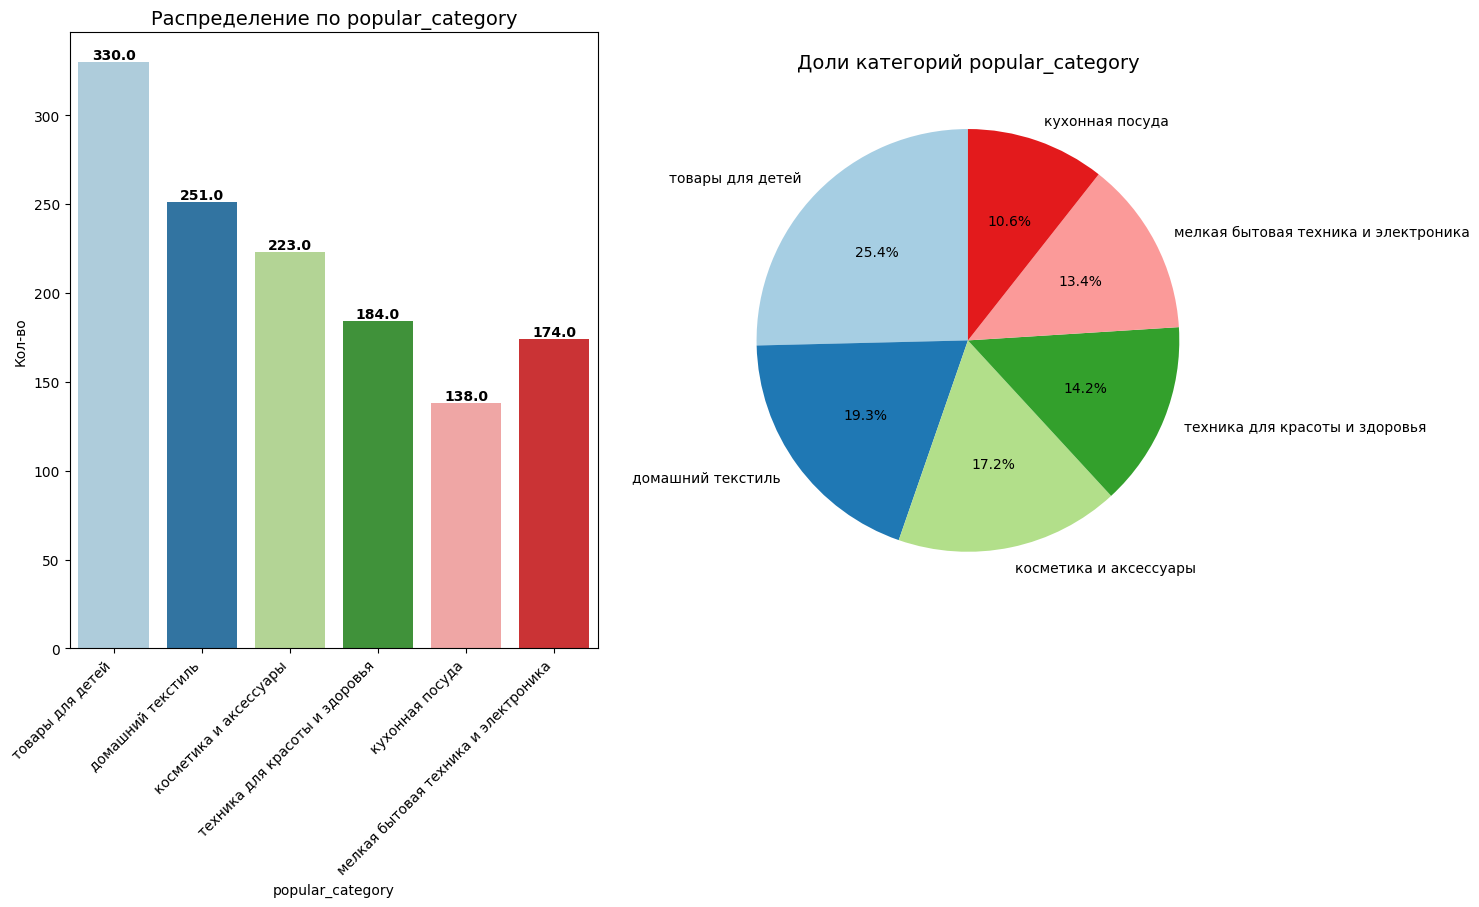

In [20]:
# Столбец 'popular_category' [Популярная_категория]
plot_categorical(market_file, column='popular_category')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику распределения категории `Популярная категория` видим, что лидер спроса - это `Товары для детей` (330 записей, доля 25.4%).

- В топ-3 также входят `домашний текстиль` и  `косметика и аксессуары`.
- А самая малопопулярная категория `кухонная посуда`.

Детская продукция формирует ядро ассортимента, однако сбалансированный спрос на товары для дома и косметику подтверждает широкий профиль покупателей. Низкий интерес к посуде указывает на потенциал для пересмотра ассортимента, функционала категории или акцентных промо-кампаний.

#### avg_categories_per_visit `[Средний просмотр категорий за визит]`

Статистика для 'avg_categories_per_visit':
Всего записей: 1300
Уникальных категорий: 6
Самая частая категория: '3' (356 записей)
Доля самой частой категории: 27.4%


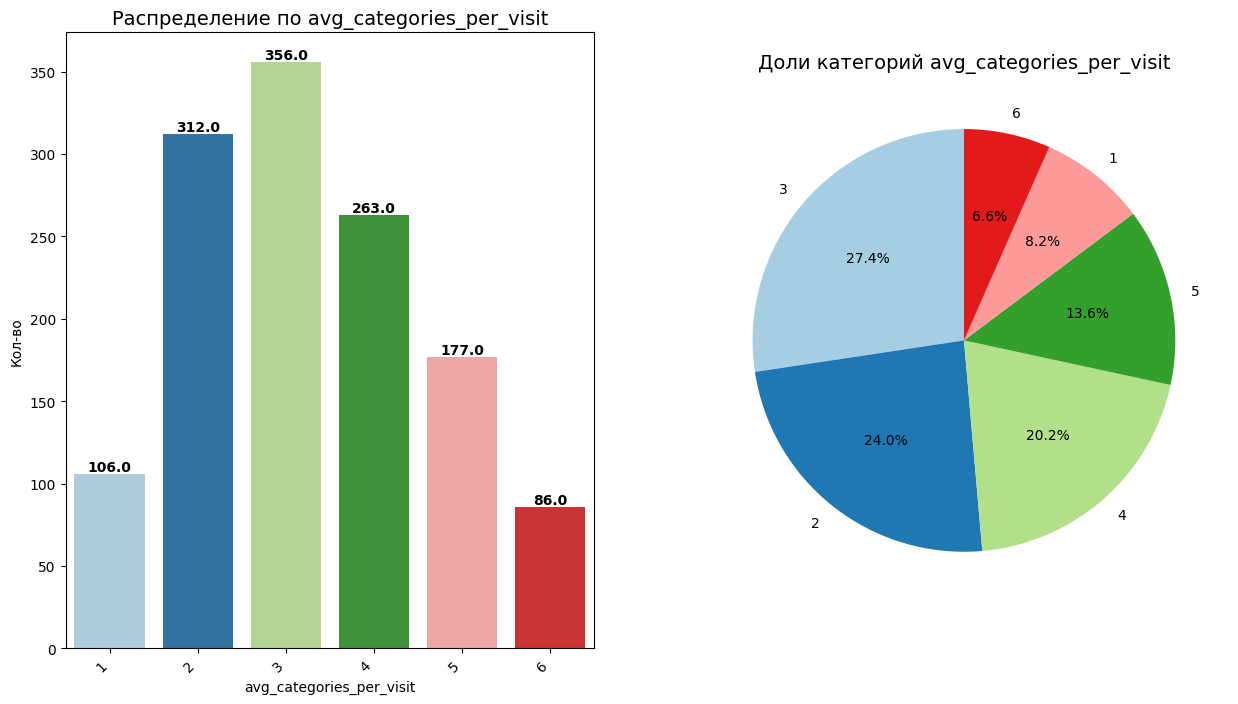

In [21]:
# Столбец 'avg_categories_per_visit' [Средний_просмотр_категорий_за_визит]
plot_categorical(market_file, 'avg_categories_per_visit')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
- По графику распределения столбца `avg_categories_per_visit` видим, что средний просмотр категорий за визит лежит в диапозоне от 1 до 6.
- Самая частая категория: `3` (356 записей, доля 27.4%)
- В топ-3 также входят `2` и `4`.
- А самая малопопулярная категория `6` и не на много от неё оторвалась категория `1`.

Переход между категориями вместо ухода может свидетельствовать о высокой вовлечённости пользователей, но одновременно может указывать на проблемы в навигации/поиске. Гистограмма в виде колокола также намекает на нормальное распределение.

#### marketing_activity_current_month `[Маркетинговая активность в текущем месяце]`

Статистика для 'marketing_activity_current_month':
Всего записей: 1300
Уникальных категорий: 3
Самая частая категория: '4' (669 записей)
Доля самой частой категории: 51.5%


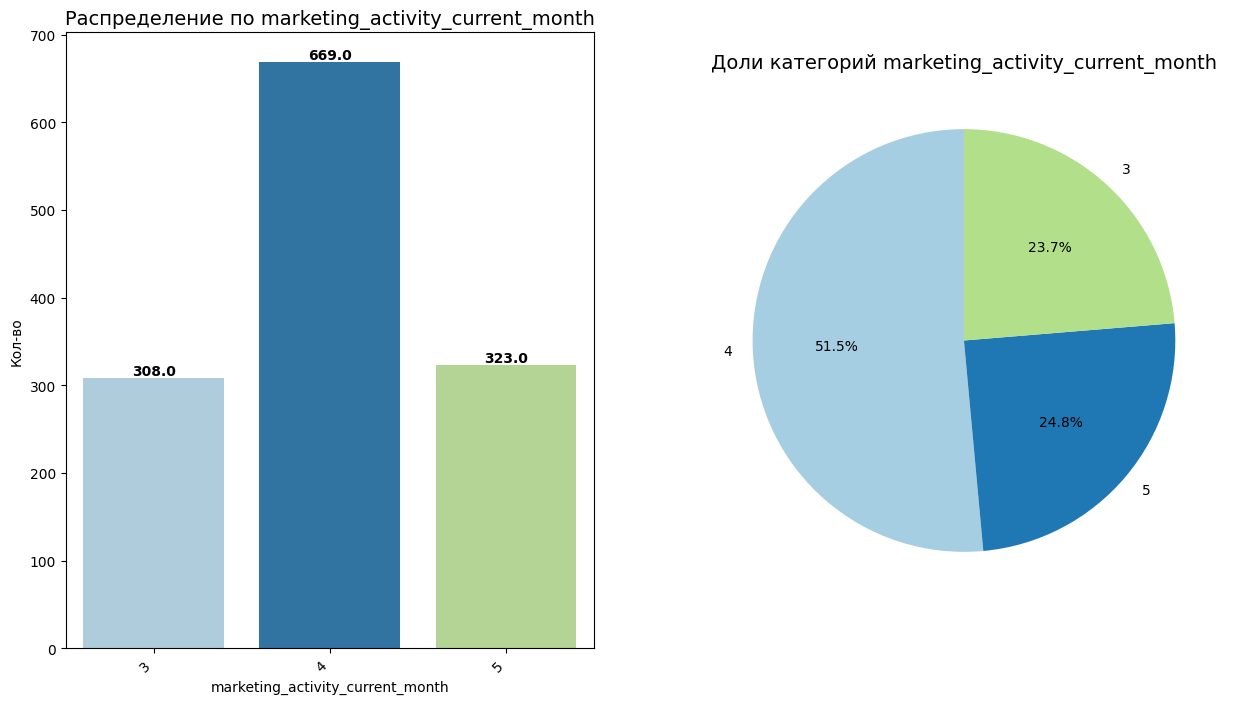

In [22]:
# Столбец 'marketing_activity_current_month' [Маркет_актив_тек_мес]
plot_categorical(market_file, 'marketing_activity_current_month')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `marketing_activity_current_month` видим, что маркетинговая активность за текущий месяц поделилась на три категории.

- Самая частая категория: `4` контакта(669 записей, доля 51.5%)
- 24.8% — `5` контактов
- 23.7% — `3` контакта

Возможно, маркетинговая стратегия сфокусирована на умеренной частоте коммуникаций (4 контакта в месяц для более половины базы), при этом аудитория практически равномерно разделена между сниженной и повышенной активностью, что может означать сегментированный подход.

#### unpaid_products_quarter `[Неоплаченные продукты штук квартал]`

Статистика для 'unpaid_products_quarter':
Всего записей: 1300
Уникальных категорий: 11
Самая частая категория: '2' (261 записей)
Доля самой частой категории: 20.1%


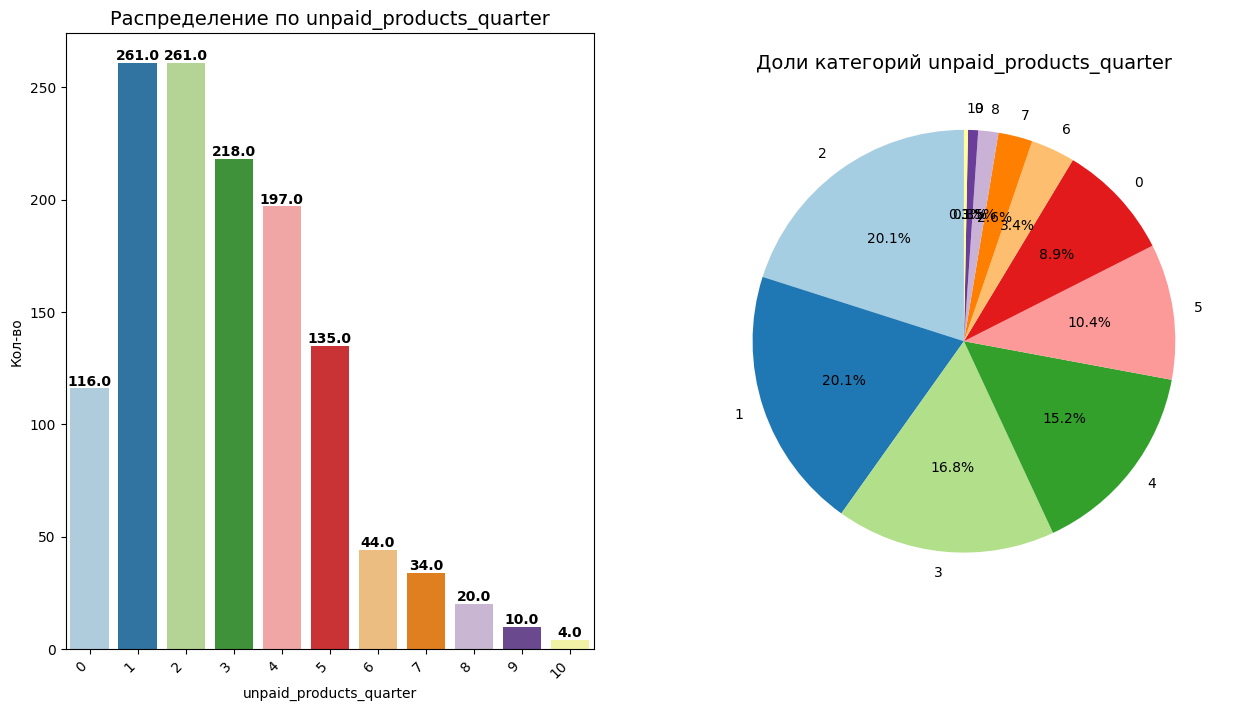

In [23]:
# Столбец 'unpaid_products_quarter' [Неоплаченные_продукты_штук_квартал]
plot_categorical(market_file, 'unpaid_products_quarter')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику распределения категории `unpaid_products_quarter` видим, что кол-во неоплаченных товаров в корзине от 0 до 10.

- Самые частые категории: `2` и `1` (по 261 записей и по 20.1% долям).
- В топ-4 также входят категории `3` и `4`— охватывают большинство случаев
- Редкие случаи: `10` неоплаченных товаров.
- Гистограмма незначительно скошена вправо. Распределение нормальное.

Большинство пользователей оставляют в корзине 1-4 неоплаченных товара, что указывает на системную проблему с конверсией на этапе оформления заказа, а не на случайные единичные случаи. Возможно, требуется оптимизация процесса покупки и напоминаний/стимулов.

#### service_error  `[Ошибка сервиса]`

Статистика для 'service_error':
Всего записей: 1300
Уникальных категорий: 10
Самая частая категория: '4' (257 записей)
Доля самой частой категории: 19.8%


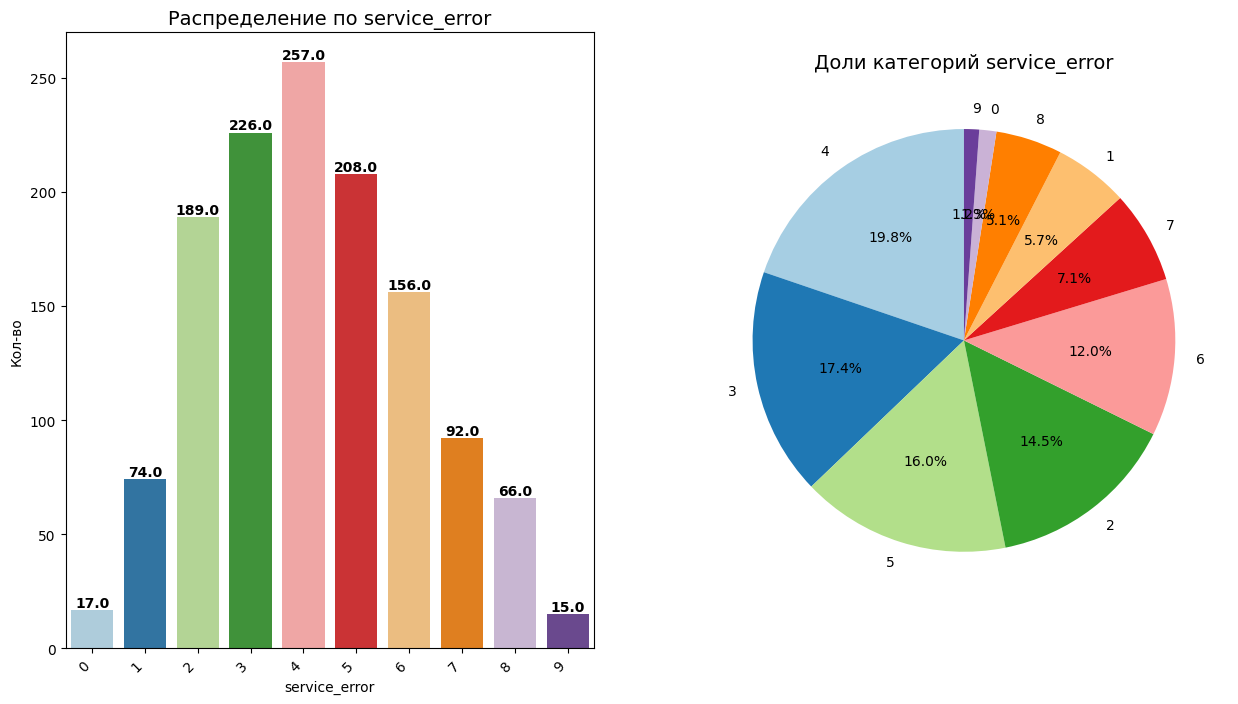

In [24]:
# Столбец 'service_error' [Ошибка_сервиса]
plot_categorical(market_file, 'service_error')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику распределения категории `service_error` видим, что число сбоев, которые коснулись покупателей во время посящения сайта за последние 3 месяца.

- Самая частая категория: `4` (257 записей, доля 19.8%)
- Топ-3: `3`, `4`, `5` сбоев - типичный опыт большинства пользователей
- Наименее частые значения: `0` и `9` сбоев
- Гистограмма в виде колокола также напоминает нормальное распределение.

Почти половина клиентов столкнулись с 3-5 сбоями за 3 месяца, что указывает на систематические проблемы с стабильностью сервиса, а не единичные инциденты.


---

<span style="color:cornflowerblue"> **ТАБЛИЦА: `market_time`**

<span style="color:cornflowerblue"> СТОЛБЕЦ:
  

#### period `[Период]`

---

Статистика для 'period':
Всего записей: 2600
Уникальных категорий: 2
Самая частая категория: 'текущий месяц' (1300 записей)
Доля самой частой категории: 50.0%


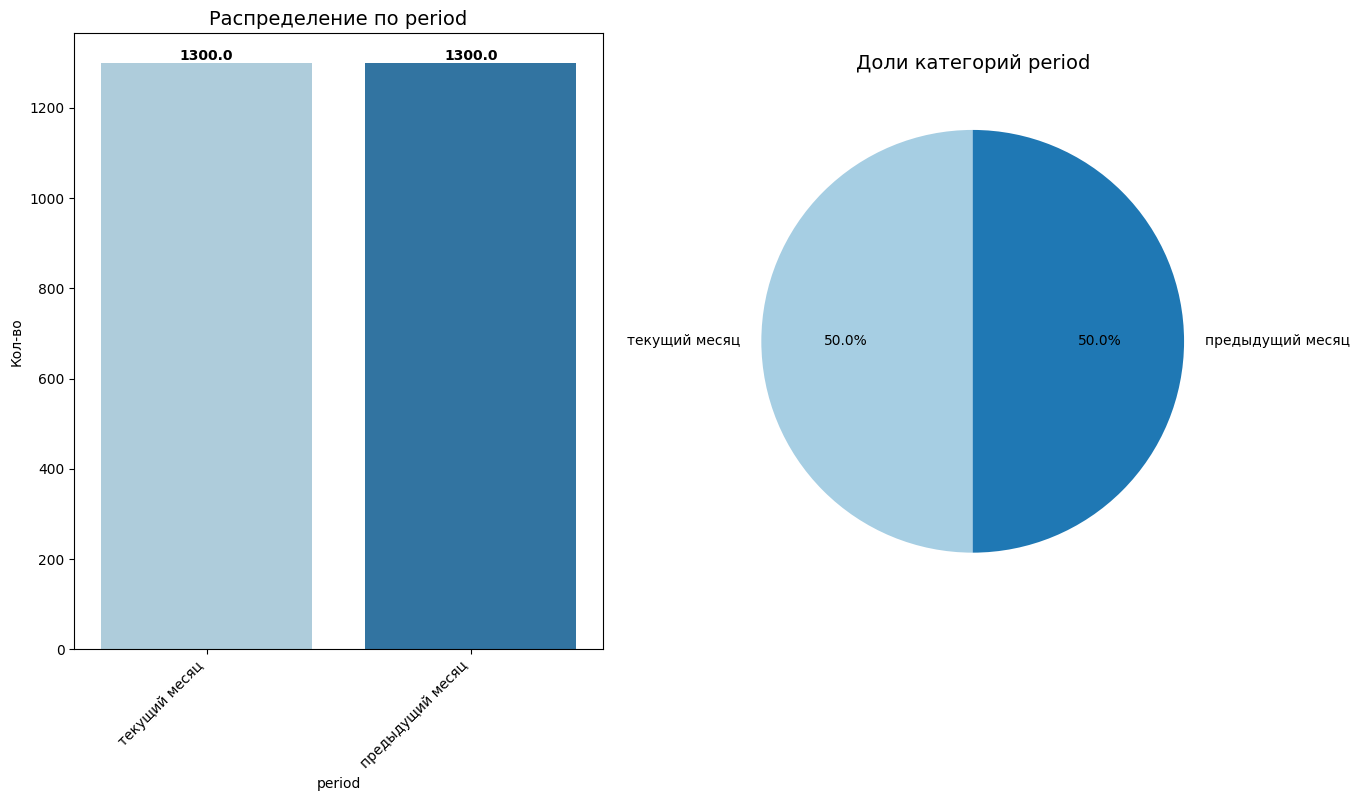

In [25]:
# Столбец 'period'[Период]
plot_categorical(market_time, column='period')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
- По графику распределения категории `Период` видим, что данные взяты равномерно за оба периода, что обеспечивает статистическую достоверность при анализе динамики и выявлении значимых изменений

---

<span style="color:cornflowerblue"> **ТАБЛИЦА: `market_money`**

<span style="color:cornflowerblue"> СТОЛБЕЦ:

#### period `[Период]`

---

Статистика для 'period':
Всего записей: 3900
Уникальных категорий: 3
Самая частая категория: 'препредыдущий месяц' (1300 записей)
Доля самой частой категории: 33.3%


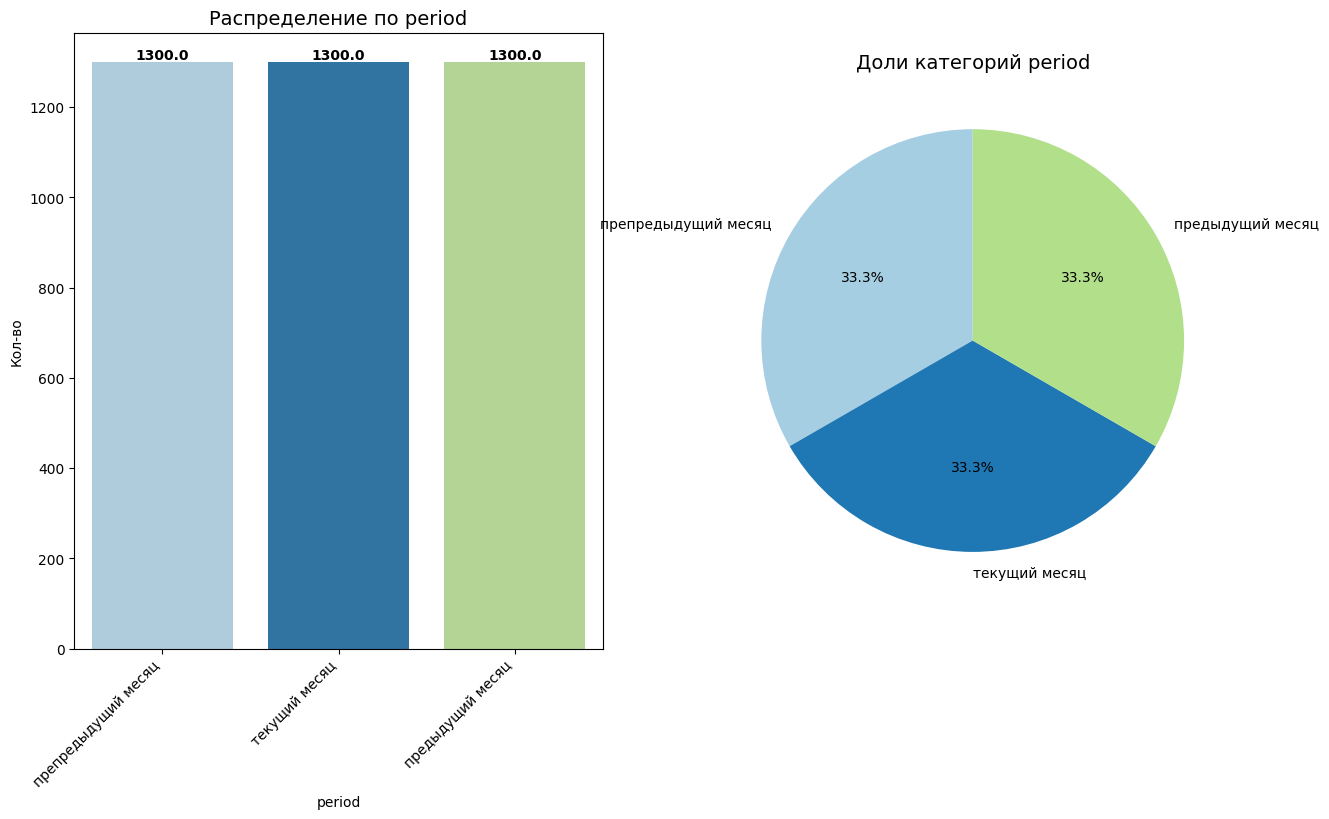

In [26]:
# Столбец 'period' [Период]
plot_categorical(market_money, column='period')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
- По графику распределения категории `Период` видим, что данные взяты равномерно за все 3 периода, что обеспечивает статистическую достоверность анализа динамики и сезонных изменений за квартал.

### 3.2 Статистика и графики распределений для количественных значений

#### <span style="color:royalblue">Функция. Ящик с усами и Гистограмма для количественных признаков

In [27]:
def plot_quantitative_new(df, column, figsize=(15, 6), palette='Paired',
                         custom_labels=None, discrete_threshold=20):
    ''' 
    Ящик с усами и Гистограмма для количественных признаков С ПРОВЕРКОЙ НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
    
    Параметры:
    -----------
    df : DataFrame - Датафрейм с данными
    column : str - Название столбца для анализа
    figsize : tuple, default=(15, 6) - размер области построения
    palette : str, default='Paired' - Цветовая палитра
    custom_labels : dict, optional - Словарь с пользовательскими подписями для графиков.
    Формат: {'название_столбца': ['название_графика', 'подпись_оси_X', 'подпись_оси_Y']}
    discrete_threshold : int, default=20 - Пороговое количество уникальных значений для определения дискретного признака
    
    '''
    
    # Создаем словарь с подписями по умолчанию
    default_labels = {
        'marketing_activity_6_months': [
            'Маркетинговая активность за 6 месяцев', 
            'Кол-во маркетинговых активностей', 
            'Кол-во пользователей'
        ],
        'duration': [
            'Длительность',
            'Дней с момента регистрации пользователя на сайте', 
            'Кол-во пользователей'
        ],
        'promotional_purchases': [
            'Акционные покупки',
            'Среднемесячная доля покупок по акции за 6 месяцев, %', 
            'Кол-во пользователей'
        ],
        'pages_per_visit': [
            'Страниц за визит',
            'Среднее кол-во страниц за 3 месяца', 
            'Кол-во пользователей'
        ],
        'revenue': [
            'Выручка',
            'Сумма выручки, у.е.', 
            'Кол-во пользователей'
        ],
        'minutes': [
            'Минут',
            'Время на сайте, минут', 
            'Кол-во пользователей'
        ],
        'profit': [
            'Прибыль',
            'Прибыль, у.е.', 
            'Кол-во пользователей'
        ]
    }
    
    # Объединяем пользовательские подписи с подписями по умолчанию
    if custom_labels:
        default_labels.update(custom_labels)
    
    labels_dict = default_labels
    
    # Получаем подписи для текущего столбца
    if column in labels_dict:
        plot_title, x_label, y_label = labels_dict[column]
    else:
        # Если столбец не найден в словаре, используем общие подписи
        plot_title = f'Распределение: {column}'
        x_label = column
        y_label = 'Кол-во пользователей'
    
    # Определяем, является ли признак дискретным
    unique_values = df[column].nunique()
    is_integer = df[column].dtype in ['int64', 'int32', 'int16', 'int8']
    is_discrete = (unique_values <= discrete_threshold and is_integer) or (unique_values <= 15)
    
    # Создаем две диаграммы
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Цвет для графиков
    color = sns.color_palette(palette, 1)[0]
    
    # 1. Ящик с усами
    sns.boxplot(data=df, y=column, color=color, ax=ax1)
    
    ax1.set_title(f'Ящик с усами: {plot_title}', fontsize=14)
    ax1.set_ylabel(x_label)
    
    # 2. Гистограмма с настройкой для дискретных/непрерывных данных
    if is_discrete:
        # Для дискретных данных используем discrete=True
        sns.histplot(data=df, x=column, discrete=True, color=color, ax=ax2, shrink=0.8)
        
        # Настраиваем целочисленные деления на оси X
        min_val = int(df[column].min())
        max_val = int(df[column].max())
        if (max_val - min_val) <= 30:  # Ограничиваем количество меток
            ax2.set_xticks(range(min_val, max_val + 1))
            
        # Для небольшого количества значений добавляем аннотации
        if unique_values <= 15:
            value_counts = df[column].value_counts().sort_index()
            for val, count in value_counts.items():
                ax2.text(val, count + max(value_counts)*0.02, 
                        f'{count}', ha='center', va='bottom', fontsize=9)
    else:
        # Для непрерывных данных используем обычную гистограмму с KDE
        sns.histplot(data=df, x=column, kde=True, color=color, ax=ax2)
    
    ax2.set_title(f'Гистограмма: {plot_title}', fontsize=14)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    
    # Добавляем линию медианы на гистограмму
    median_val = df[column].median()
    ax2.axvline(median_val, color='red', linestyle='--', 
                label=f'Медиана: {median_val:.3f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистики с информацией о типе данных
    print(f"Статистика для '{plot_title}':")
    print('-' * 50)
    stats = df[column].describe()
    print(f"Тип данных: {'Дискретный' if is_discrete else 'Непрерывный'}")
    print(f"Уникальных значений: {unique_values}")
    print(f"Кол-во записей: {stats['count']:.0f}")
    print(f"Среднее: {stats['mean']:.3f}")
    print(f"Стандартное отклонение: {stats['std']:.3f}")
    print(f"Медиана: {stats['50%']:.3f}")
    print(f"Минимум: {stats['min']:.3f}")
    print(f"Максимум: {stats['max']:.3f}")
    print(f"25-й перцентиль: {stats['25%']:.3f}")
    print(f"75-й перцентиль: {stats['75%']:.3f}")
    
    # Проверка на нормальность распределения
    if len(df[column].dropna()) >= 3:
        print(f"\nПроверка на нормальность распределения (α=0.05):")
        print('-' * 50)
        data = df[column].dropna()
        
        # Критерий Шапиро-Уилка
        if len(data) <= 5000:
            shapiro_stat, shapiro_p = shapiro(data)
            shapiro_normal = shapiro_p > 0.05
            print(f"Критерий Шапиро-Уилка: p-value = {shapiro_p:.4f} {'> 0.05 (нормальное)' if shapiro_normal else '< 0.05 (не нормальное)'}")
        
        # Критерий Д'Агостино
        try:
            dagostino_stat, dagostino_p = normaltest(data)
            dagostino_normal = dagostino_p > 0.05
            print(f"Критерий Д'Агостино: p-value = {dagostino_p:.4f} {'> 0.05 (нормальное)' if dagostino_normal else '< 0.05 (не нормальное)'}")
            
            # Итоговый вывод
            if dagostino_p > 0.05:
                print('ВЫВОД: распределение соответствует нормальному')
            else:
                print('ВЫВОД: распределение НЕ соответствует нормальному')
                
        except Exception as e:
            print(f'Ошибка при проверке на нормальное распределение: {e}')
    else:
        print(f'\nПримечание: недостаточно данных для проверки на нормальное распределение (n < 3)')

---

<span style="color:cornflowerblue"> **ТАБЛИЦА: `market_file`**

<span style="color:cornflowerblue"> СТОЛБЕЦ:

- **marketing_activity_6_months** `[Маркетинговая коммуникация за последни 6 месяцев]`
- **duration** `[Длительность]`
- **promotional_purchases** `[Акционные покупки]`
- **pages_per_visit** `[Страниц за визит]`
  
---

#### marketing_activity_6_months `[Маркетинговая коммуникация за последни 6 месяцев]`

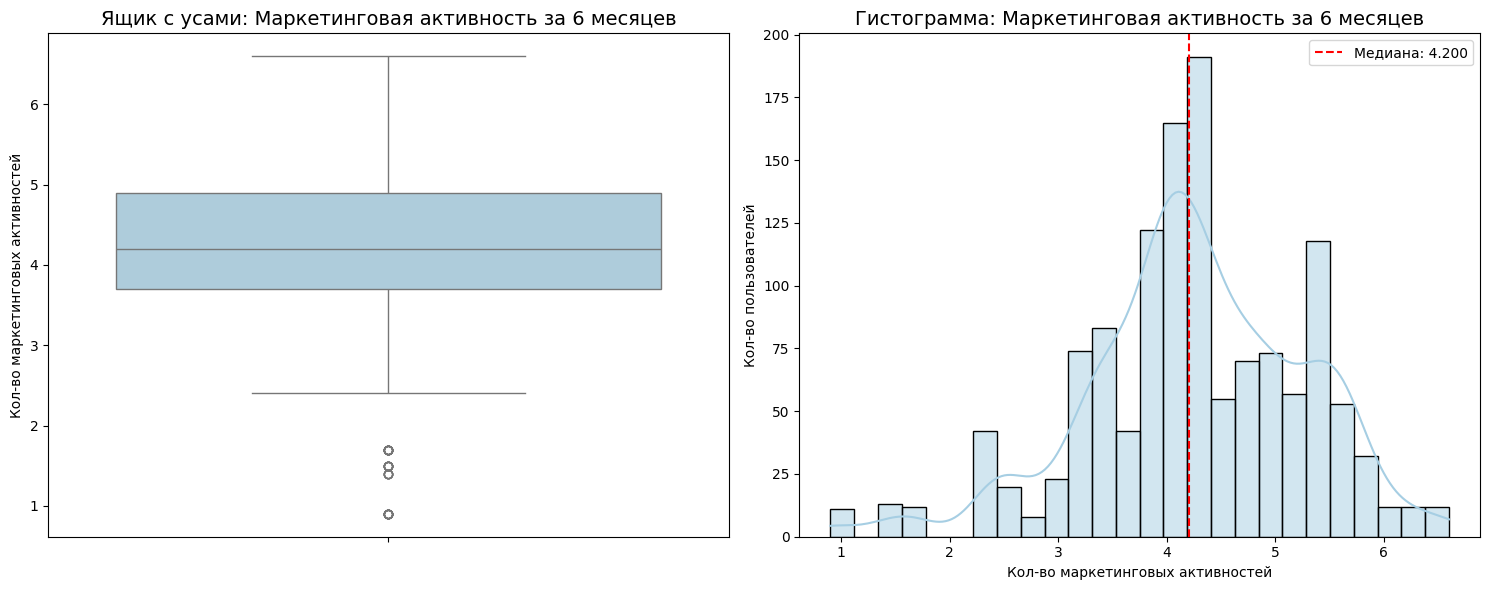

Статистика для 'Маркетинговая активность за 6 месяцев':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 41
Кол-во записей: 1300
Среднее: 4.254
Стандартное отклонение: 1.015
Медиана: 4.200
Минимум: 0.900
Максимум: 6.600
25-й перцентиль: 3.700
75-й перцентиль: 4.900

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [28]:
# Столбец 'marketing_activity_6_months'  [Маркетинговая коммуникация за последни 6 месяцев]
plot_quantitative_new(market_file, 'marketing_activity_6_months')

<div style="background-color: white; border: 2px solid pink; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения признака `Маркетинговая коммуникация за последни 6 месяцев` видим, что среднемесячное значение маркетинговой коммуникации за последни 6 месяцев:
    
    - в среднем 4.3
    - медиана 4.2
    - Стандартное отклонение 1.01 указывает на умеренный разброс данных.
    
- Выбросы минимальны и сохранены для анализа. Данные столбца без аномальных значений.
- Маркетинговая коммуникация демонстрирует стабильную интенсивность (~4 контакта в месяц) с незначительными отклонениями между клиентами, что свидетельствует может свидетельствовать о системном CRM-подходе (50% клиентов получают 3.7-4.9 контактов).

---

- Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
- Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
    
<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**



#### duration `[Длительность]`

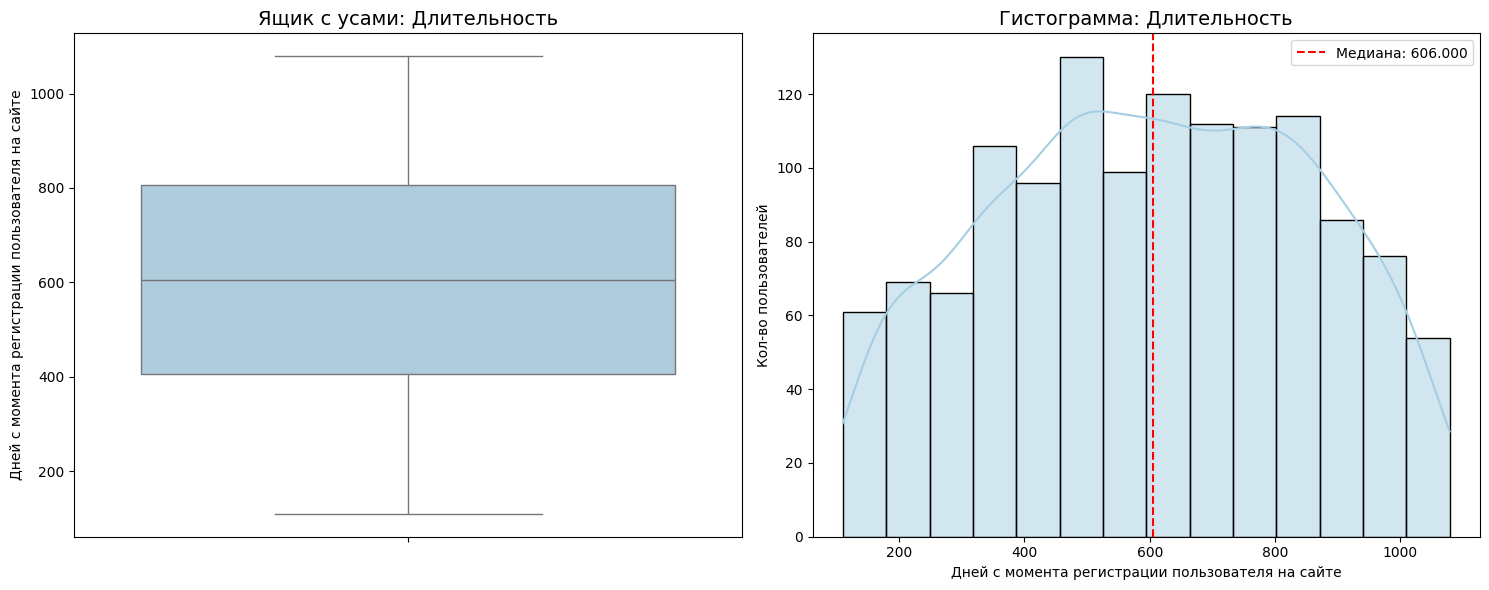

Статистика для 'Длительность':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 658
Кол-во записей: 1300
Среднее: 601.898
Стандартное отклонение: 249.856
Медиана: 606.000
Минимум: 110.000
Максимум: 1079.000
25-й перцентиль: 405.500
75-й перцентиль: 806.000

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [29]:
# Столбец 'duration' [Длительность]
plot_quantitative_new(market_file, 'duration')

<div style="background-color: white; border: 2px solid pink; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику признака `Длительность` видим распределение значений, которые показывают сколько дней прошло с момента регистрации покупателя на сайте:
    
    - в среднем 602 дня
    - медиана 606 дней
    - Стандартное отклонение 250 дней указывает на значительный разброс данных
    - Диапазон от 110 до 1079 дней охватывает всех пользователей без аномалий

    
- Основная часть значений лежит в диапозоне от 405 до 806 дней. Выбросы и аномальные значения в данных отсутствуют.
- Данные сбалансированны между новыми и постоянными пользователями, что указывает на устойчивый поток регистраций без перекоса в какую-либо временную группу.

---

- Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
- Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
    
<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

#### promotional_purchases `[Акционные покупки]`

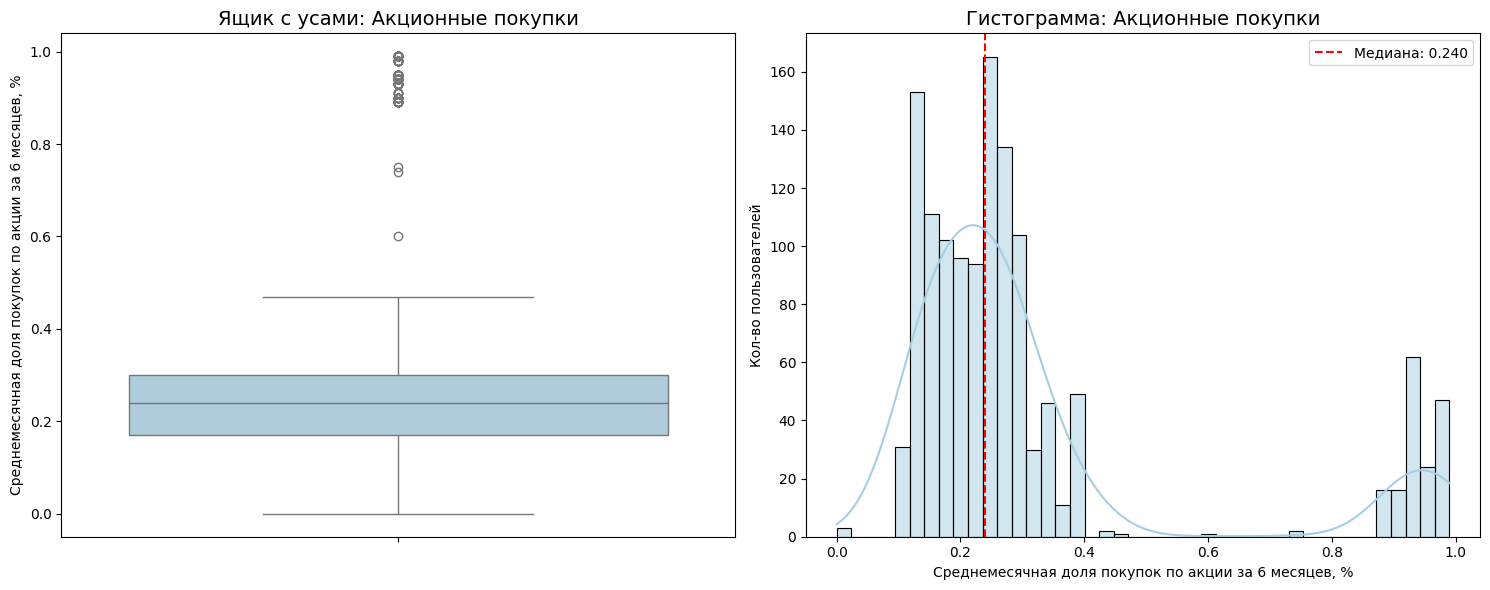

Статистика для 'Акционные покупки':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 42
Кол-во записей: 1300
Среднее: 0.320
Стандартное отклонение: 0.250
Медиана: 0.240
Минимум: 0.000
Максимум: 0.990
25-й перцентиль: 0.170
75-й перцентиль: 0.300

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [30]:
# Столбец 'promotional_purchases' [Акционные покупки]
plot_quantitative_new(market_file, 'promotional_purchases')

<div style="background-color: white; border: 2px solid pink; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику признака `promotional_purchases` видим распределение среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев:
    
    - Распределение с правым смещением: среднее 0.32% > медиана 0.24%
    - Стандартное отклонение 0.25% указывает на умеренный разброс
    
- Основная часть значений лежит в диапозоне от 0.17 до 0.30. Есть выбросы и так как разброс значений в малом диапозоне - оставим их. Аномальных значений нет.
- Диапозон всех значений в данных от 0 до 0.99.
- Большинство клиентов совершают менее трети покупок по акциям, при этом наличие правого хвоста распределения указывает на сегмент "акционных охотников" с высокой долей промо-покупок.

---

- Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
- Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)

    
<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

#### pages_per_visit `[Страниц за визит]`

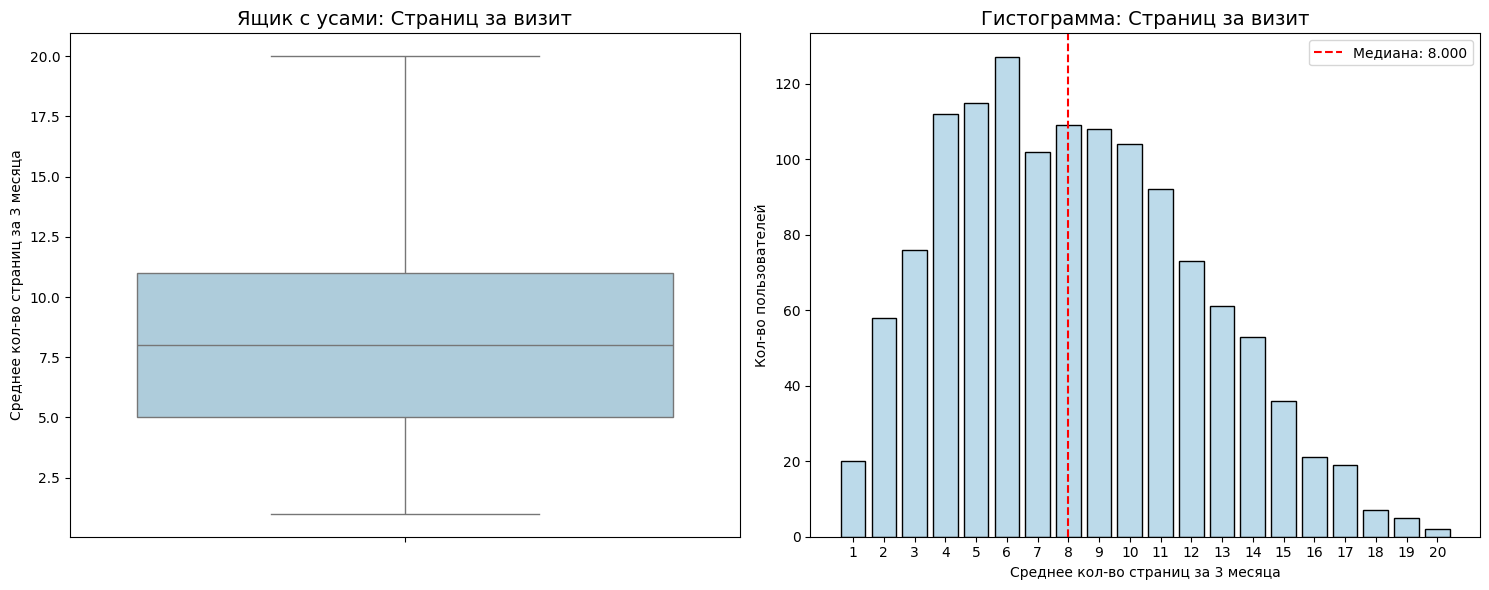

Статистика для 'Страниц за визит':
--------------------------------------------------
Тип данных: Дискретный
Уникальных значений: 20
Кол-во записей: 1300
Среднее: 8.177
Стандартное отклонение: 3.978
Медиана: 8.000
Минимум: 1.000
Максимум: 20.000
25-й перцентиль: 5.000
75-й перцентиль: 11.000

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [31]:
# Столбец 'pages_per_visit' [Страниц за визит]
plot_quantitative_new(market_file, 'pages_per_visit')

<div style="background-color: white; border: 2px solid pink; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику признака `Страниц за визит` видим распределение среднего кол-ва страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца :
    
    - Распределение умеренно скошено вправо при близких значениях среднего (8.2) и медианы (8.0)
    - Стандартное отклонение 4 указывает на умеренный разброс поведения пользователей
    - 50% посетителей просматривают от 5 до 11 страниц за визит
    - Диапазон от 1 до 20 страниц. Выбросы и аномалии отсутствуют.

- Незначительный правый хвост распределения свидетельствует о наличии сегмента высокововлеченных пользователей, просматривающих более 11 страниц за визит.
- При этом большинство клиентов демонстрирует стабильное поведение (~8 страниц), что может свидетельствовать о хорошей вовлеченности/лояльности/эффективной структуре сайта.

---

- Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
- Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)

<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

---

<span style="color:cornflowerblue"> **ТАБЛИЦА: `market_money`**

<span style="color:cornflowerblue"> СТОЛБЕЦ:


#### revenue `[Выручка]`
---

In [32]:
# Заранее выведу выброс, который мешает адекватной визуализации и исключим неактивных пользователей

display(market_money.loc[market_money['revenue'] > 8000])

,id,period,revenue
98,215380,текущий месяц,106862.2


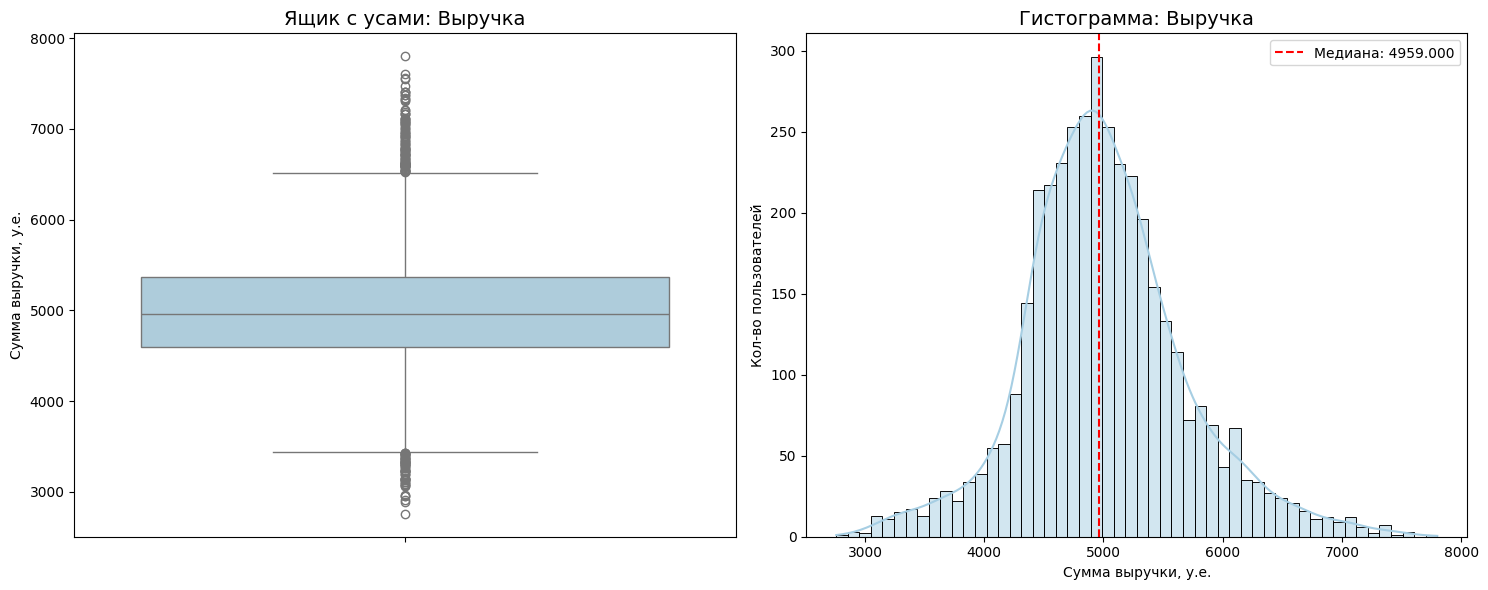

Статистика для 'Выручка':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 2774
Кол-во записей: 3893
Среднее: 5007.283
Стандартное отклонение: 679.725
Медиана: 4959.000
Минимум: 2758.700
Максимум: 7799.400
25-й перцентиль: 4592.000
75-й перцентиль: 5363.000

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [33]:
# Столбец 'revenue' [Выручка]
# Перезапишем таблицу и выведем графики
market_money = market_money.loc[market_money['revenue'] < 8000]
plot_quantitative_new(market_money.loc[market_money['revenue'] > 0], 'revenue')

<div style="background-color: white; border: 2px solid pink; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графику признака `выручка` видим распределение суммы выручки за период в условных единицах:
    
    - Распределение близко к нормальному со средним 5007 и медианой 4959.
    - Стандартное отклонение 680 указывает на умеренный разброс значений.
    - 50% данных находятся в диапазоне от 4592 до 5363.
    - Исключили аномальное значение(106862) исключили. 

- Нулевые значения не учитываем (с ними мы расправимся в пункте 3.3). 

---

- Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
- Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)

    
<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

---

<span style="color:cornflowerblue"> **ТАБЛИЦА: `market_time`**

<span style="color:cornflowerblue"> СТОЛБЕЦ:


#### minutes `[Минут]`

---

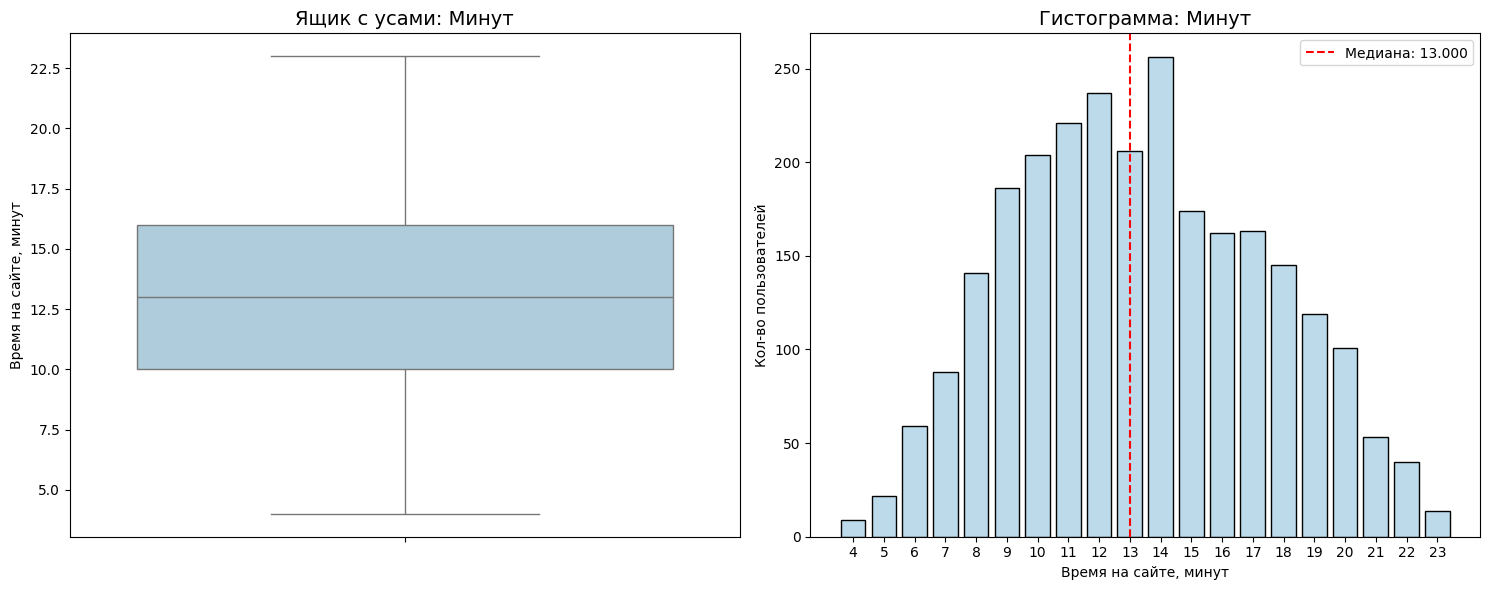

Статистика для 'Минут':
--------------------------------------------------
Тип данных: Дискретный
Уникальных значений: 20
Кол-во записей: 2600
Среднее: 13.336
Стандартное отклонение: 4.080
Медиана: 13.000
Минимум: 4.000
Максимум: 23.000
25-й перцентиль: 10.000
75-й перцентиль: 16.000

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [34]:
# Столбец 'minutes' [минут]
plot_quantitative_new(market_time, 'minutes')

<div style="background-color: white; border: 2px solid pink; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графикам признака `минут` видим распределения значение времени, проведенного на сайте:
    
    - в среднем 13.3 минуты
    - медиана 13 минут
    - Стандартное отклонение 4.1 минуты указывает на умеренный разброс
    - Полный диапазон от 4 до 23 минут охватывает все наблюдения без выбросов и аномалий
    
- Пользователи демонстрируют стабильную модель вовлеченности, проводя в среднем 13 минут на сайте, что свидетельствует о достаточном времени для ознакомления с контентом и совершения целевых действий.

---

- Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
- Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)

<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

---

<span style="color:cornflowerblue"> **ТАБЛИЦА: `money`**

<span style="color:cornflowerblue"> СТОЛБЕЦ:


#### profit `[Прибыль]`

---

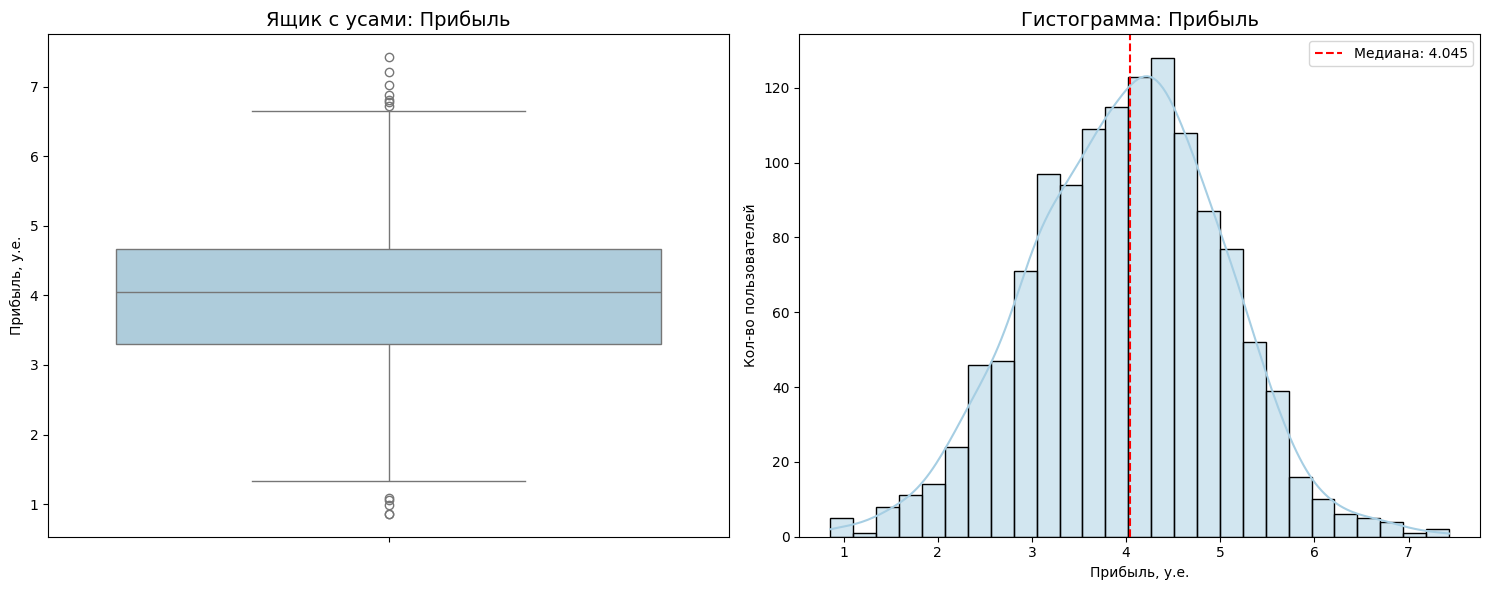

Статистика для 'Прибыль':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 400
Кол-во записей: 1300
Среднее: 3.997
Стандартное отклонение: 1.014
Медиана: 4.045
Минимум: 0.860
Максимум: 7.430
25-й перцентиль: 3.300
75-й перцентиль: 4.670

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.2583 > 0.05 (нормальное)
Критерий Д'Агостино: p-value = 0.4887 > 0.05 (нормальное)
ВЫВОД: распределение соответствует нормальному


In [35]:
# Столбец 'profit' [Прибыль]
plot_quantitative_new(money, 'profit')

<div style="background-color: white; border: 2px solid pink; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">
    
По графикам признака `прибыль` видим распределения значение прибыли в условных единицах:
    
- Распределение близко к нормальному со средним 4.0 и медианой 4.05 y.e.
- Стандартное отклонение 1.01 y.e. указывает на умеренную вариативность значений прибыли.
- 50% данных с прибылью от 3.3 до 4.7 y.e.
- Полный диапазон от 0.9 до 7.4 y.e. охватывает все наблюдения без значительных аномалий и выбросов.
    
---

- Критерий Шапиро-Уилка: p-value = 0.2583 > 0.05 (нормальное)
- Критерий Д'Агостино: p-value = 0.4887 > 0.05 (нормальное)

<span style="color:crimson"> **Распределение соответствует нормальному.**

### 3.3 Отбор активных пользователей

<span style="color:cornflowerblue"> [Это пользователи, которые делали покупки на протяжении как минимум трёх месяцев подряд]

In [36]:
# Размерности датасетов до очистки
datasets = [market_file, market_money, market_time, money]
names = ['market_file', 'market_money', 'market_time', 'money']

print('ДО очистки:')
for name, df in zip(names, datasets):
    print(f'{name}: {df.shape}')

# Удаляем пользователей без покупок
user_inactive = market_money[market_money['revenue'] == 0]['id'].unique()

for df in datasets:
    df.drop(df[df['id'].isin(user_inactive)].index, inplace=True)

print('\nПОСЛЕ очистки:')
for name, df in zip(names, datasets):
    print(f'{name}: {df.shape}')

ДО очистки:
market_file: (1300, 13)
market_money: (3899, 3)
market_time: (2600, 3)
money: (1300, 2)

ПОСЛЕ очистки:
market_file: (1297, 13)
market_money: (3890, 3)
market_time: (2594, 3)
money: (1297, 2)


<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---
    
В данном разделе мы провели статистический анализ всех признаков, прежде разделив их на **категориальные** и **количественные**. Построили графики для каждого признака. 
    
    - Для количественных признаков мы построили: "Ящик с усами" и Гистограмму.
    - Для категориальных признаков мы построили: Столбчатую и круговую диаграммы.

- Убрали аномальное значение 106862 у.е. в столбце `revenue`, перезаписав таблицу `market_money`.
- Удалили все записи пользователей (всего 3 пользователя) из всех таблиц, которые не делали покупки на протяжении трёх месяцев подряд.
       
---
    
**ОБЩИЕ ВЫВОДЫ ПО ПРИЗНАКАМ**
    
К А Т Е Г О Р И А Л Ь Н Ы Е 

<span style="color:cornflowerblue"> ТАБЛИЦА: **`market_file`**

- **purchase_activity** `[Покупательская активность]`
  
Преобладание стабильных клиентов(61.7%), значительная доля (каждый третий) показывает снижение активности(38.3%), что указывает на необходимость срочных мер по удержанию.

- **service_type** `[Тип сервиса]`


Преимущественно пользователи стандартного тарифа(71.1%), при этом премиум-сегмент составляет значительную долю (~29%), что свидетельствует о потенциале для монетизации.

- **allow_notifications** `[Разрешить сообщать]`

Большинство клиентов лояльны к дополнительным коммуникациям (74%), что открывает значительные возможности для персонализированной маркетинговой активности.

- **popular_category** `[Популярная категория]`

Спрос на детскую продукцию лидирует (25.4%), однако сбалансированный спрос на товары для дома(19.3%) и косметику(17.2%) подтверждает широкий профиль покупателей. Низкий интерес к посуде (10.6%) указывает на потенциал для пересмотра ассортимента, функционала категории или акцентных промо-кампаний.

- **avg_categories_per_visit** `[Средний просмотр категорий за визит]`

Наибольшее кол-во пользователей в среднем смотрят от 3 до 4 категорий за визит. Чаще всего пользователи смотрят 3 категории(27.4%), а меньше всего 6 и 1 категорий за визит. Переход между категориями вместо ухода может свидетельствовать о высокой вовлечённости пользователей, но одновременно может указывать на проблемы в навигации/поиске.

- **marketing_activity_current_month** `[Маркетинговая активность в текущем месяце]`

Самая частая категория: 4 контакта(51.5%). Возможно, маркетинговая стратегия сфокусирована на умеренной частоте коммуникаций (4 контакта в месяц для более половины базы), при этом аудитория практически равномерно разделена между сниженной(23.7%) и повышенной активностью(24.8%), что может означать сегментированный подход.

- **unpaid_products_quarter** `[Неоплаченные продукты штук квартал]`

Самые частые категории: 2 и 1 (по 20.1%).
Большинство пользователей оставляют в корзине 1-4 неоплаченных товара, что указывает на системную проблему с конверсией на этапе оформления заказа, а не на случайные единичные случаи. Возможно, требуется оптимизация процесса покупки и напоминаний/стимулов.

- **service_error**  `[Ошибка сервиса]`

Почти половина клиентов столкнулись с 3-5 сбоями за 3 месяца, что указывает на систематические проблемы с стабильностью сервиса, а не единичные инциденты.
  
<span style="color:cornflowerblue"> ТАБЛИЦА: **`market_time`**

- **period** `[Период]`
Доли в данных равны(по 50%) за оба периода, что обеспечивает статистическую достоверность при анализе динамики и выявлении значимых изменений.

<span style="color:cornflowerblue"> ТАБЛИЦА: **`market_money`**

- **period** `[Период]`
Данные взяты равномерно за все 3 периода, что обеспечивает статистическую достоверность анализа динамики и сезонных изменений за квартал.

К О Л И Ч Е С Т В Е Н Н Ы Е

<span style="color:cornflowerblue"> ТАБЛИЦА: **`market_file`**
    
- **marketing_activity_6_months** `[Маркетинговая коммуникация за последни 6 месяцев]`
<span style="color:cornflowerblue"> **Распределение НЕ соответствует нормальному.**
  
Маркетинговая коммуникация демонстрирует стабильную интенсивность (~4 контакта в месяц) с незначительными отклонениями между клиентами, что свидетельствует может свидетельствовать о системном CRM-подходе (50% клиентов получают 3.7-4.9 контактов).

- **duration** `[Длительность]`
<span style="color:cornflowerblue"> **Распределение НЕ соответствует нормальному.**

Данные сбалансированны между новыми и постоянными пользователями, что указывает на устойчивый поток регистраций без перекоса в какую-либо временную группу.

- **promotional_purchases** `[Акционные покупки]`
<span style="color:cornflowerblue"> **Распределение НЕ соответствует нормальному.**

Большинство клиентов совершают менее трети покупок по акциям, при этом наличие правого хвоста распределения указывает на сегмент "акционных охотников" с высокой долей промо-покупок.
    
- **pages_per_visit** `[Страниц за визит]` 
<span style="color:cornflowerblue"> **Распределение НЕ соответствует нормальному.**

Незначительный правый хвост распределения свидетельствует о наличии сегмента высокововлеченных пользователей, просматривающих более 11 страниц за визит. При этом большинство клиентов демонстрирует стабильное поведение (~8 страниц), что может свидетельствовать о хорошей вовлеченности/лояльности/эффективной структуре сайта.

<span style="color:cornflowerblue"> ТАБЛИЦА: **`market_time`**

- **minutes** `[Минут]`
<span style="color:cornflowerblue"> **Распределение НЕ соответствует нормальному.**

Пользователи демонстрируют стабильную модель вовлеченности, проводя в среднем 13 минут на сайте, что свидетельствует о достаточном времени для ознакомления с контентом и совершения целевых действий.

<span style="color:cornflowerblue"> ТАБЛИЦА: **`market_money`** 

- **revenue** `[Выручка]` 
<span style="color:cornflowerblue"> **Распределение НЕ соответствует нормальному).**

<span style="color:cornflowerblue"> ТАБЛИЦА: **`money`**

- **profit** `[Прибыль]`
<span style="color:cornflowerblue"> **Распределение соответствует нормальному.**

Полный диапазон от 0.9 до 7.4 y.e. охватывает все наблюдения без значительных аномалий и выбросов.

---
    
<span style="color:cornflowerblue"> ДАЛЕЕ ОБЪЕДИНИМ ТАБЛИЦЫ `market_file`, `market_money`, `market_time`. ГДЕ:

- Соберем два датасета `Обучающий` и `Предсказательный`
- Создадим отдельные столбцы для каждого периода.



## Шаг 4. Объединение таблиц

### Объединяем

In [37]:
# Создаем отдельные столбцы для каждого периода
pivot_money = market_money.pivot(index='id', #Строки - уникальные id
                                 columns='period', #Столбцы - периоды
                                 values='revenue') #Значения - выручка
pivot_time = market_time.pivot(index='id', #Строки - уникальные id
                               columns='period', #Столбцы - периоды
                               values='minutes') #Значения - минуты

# Объединяем с основной таблицей
modeling_df = (market_file
                 .merge(pivot_money, on='id', how='inner')
                 .merge(pivot_time, on='id', how='inner', suffixes=('_revenue', '_minutes'))
              )

# Переименовываем столбцы на английский
column_rename = {
    'предыдущий месяц_revenue': 'previous_month_revenue',
    'препредыдущий месяц': 'two_months_ago_revenue',
    'текущий месяц_revenue': 'current_month_revenue',
    'предыдущий месяц_minutes': 'previous_month_minutes', 
    'текущий месяц_minutes': 'current_month_minutes'
}

modeling_df = modeling_df.rename(columns=column_rename)

# Проверяем пропуски в данных revenue и удаляем проблемных пользователей
revenue_columns = ['current_month_revenue', 'previous_month_revenue', 'two_months_ago_revenue']

print('Проверка пропусков в данных revenue:')
for col in revenue_columns:
    nan_count = modeling_df[col].isnull().sum()
    if nan_count > 0:
        users_with_nan = modeling_df[modeling_df[col].isnull()]['id'].tolist()
        print(f'Пропуски в {col}: {nan_count}')
        print(f'ID пользователей с пропусками: {users_with_nan}')
        
        # Удаляем всех пользователей с пропусками
        modeling_df = modeling_df[~modeling_df['id'].isin(users_with_nan)]
        print(f'Удалено пользователей: {len(users_with_nan)}')

print('\nФинальная статистика:')
print(f'Строки: {modeling_df.shape[0]}, Столбцы: {modeling_df.shape[1]}')
print(f'Уникальных пользователей: {modeling_df['id'].nunique()}')
print('Пропуски в данных:')
print(modeling_df.isnull().sum())
print(f'Дубликатов: {modeling_df.duplicated().sum()}')

Проверка пропусков в данных revenue:
Пропуски в current_month_revenue: 1
ID пользователей с пропусками: [215380]
Удалено пользователей: 1

Финальная статистика:
Строки: 1296, Столбцы: 18
Уникальных пользователей: 1296
Пропуски в данных:
id                                  0
purchase_activity                   0
service_type                        0
allow_notifications                 0
marketing_activity_6_months         0
marketing_activity_current_month    0
duration                            0
promotional_purchases               0
popular_category                    0
avg_categories_per_visit            0
unpaid_products_quarter             0
service_error                       0
pages_per_visit                     0
previous_month_revenue              0
two_months_ago_revenue              0
current_month_revenue               0
previous_month_minutes              0
current_month_minutes               0
dtype: int64
Дубликатов: 0


### 4.2 Собираем датасеты для моделирования

---

**Мы используем скользящий трёхмесячный период, где:**

- `Обучающий датасет`: два завершенных месяца (предыдущий и предпредыдущий).

- `Предсказательный датасет`: текущий месяц и месяц вперед.

Поскольку у нас нет данных из будущего, мы используем актуальные данные за последние два месяца для оценки активности на месяц вперед.

---

In [38]:
# Собирем Обучающий датасет и добавим новый столбец `diff_revenue`
modeling_df_train = modeling_df.copy()
modeling_df_train['diff_revenue'] = modeling_df_train['previous_month_revenue'] - modeling_df_train['two_months_ago_revenue']
modeling_df_train = modeling_df_train.drop(columns=['previous_month_revenue','two_months_ago_revenue', 'current_month_revenue'])
modeling_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1296
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1296 non-null   int64  
 1   purchase_activity                 1296 non-null   object 
 2   service_type                      1296 non-null   object 
 3   allow_notifications               1296 non-null   object 
 4   marketing_activity_6_months       1296 non-null   float64
 5   marketing_activity_current_month  1296 non-null   int64  
 6   duration                          1296 non-null   int64  
 7   promotional_purchases             1296 non-null   float64
 8   popular_category                  1296 non-null   object 
 9   avg_categories_per_visit          1296 non-null   int64  
 10  unpaid_products_quarter           1296 non-null   int64  
 11  service_error                     1296 non-null   int64  
 12  pages_per_v

In [39]:
# Собирем Предсказательный датасет и добавим новый столбец `diff_revenue`
modeling_df_pred = modeling_df.copy()
modeling_df_pred['diff_revenue'] = modeling_df_pred['current_month_revenue'] - modeling_df_pred['previous_month_revenue']
modeling_df_pred = modeling_df_pred.drop(columns=['previous_month_revenue','two_months_ago_revenue', 'current_month_revenue'])
modeling_df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1296
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1296 non-null   int64  
 1   purchase_activity                 1296 non-null   object 
 2   service_type                      1296 non-null   object 
 3   allow_notifications               1296 non-null   object 
 4   marketing_activity_6_months       1296 non-null   float64
 5   marketing_activity_current_month  1296 non-null   int64  
 6   duration                          1296 non-null   int64  
 7   promotional_purchases             1296 non-null   float64
 8   popular_category                  1296 non-null   object 
 9   avg_categories_per_visit          1296 non-null   int64  
 10  unpaid_products_quarter           1296 non-null   int64  
 11  service_error                     1296 non-null   int64  
 12  pages_per_v

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---
    
В данном разделе мы объединили данные таблиц `market_file`,`market_time`,`market_money` в одну **`modeling_df`**:

- Создали отдельные столбцы для каждого периода таблицы `market_money` и таблицы `market_time`
- Объединяем с основной таблицей и переименовываем новые столбцы на английский
- Сделали проверку пропусков в данных revenue и удалили пользователя, у которого прежде было аномальное значение

<span style="color:cornflowerblue"> И Т О Г:

- ID удаленного пользователя с 1 пропуском: [215380]
- Строк: 1296, Столбцов: 18
- Уникальных пользователей: 1296

---

На основе `modeling_df` создали два отдельных датасета **`modeling_df_train`**(Обучающий) и **`modeling_df_pred`**(Предсказательный) для последующео моделирования и предсказания пользовательской активности на следующий месяц:

- Создали новый столбец `diff_revenue` в таблице `modeling_df_train` для описания ТЕКУЩЕГО целевого признака
- Создали новый столбец `diff_revenue` в таблице `modeling_df_pred` для описания БУДУЩЕГО целевого признака
- И удалили в обоих выручки по периодам

---
    
<span style="color:cornflowerblue"> ДАЛЕЕ ПРОВЕДЕМ КОРРЕЛЯЦИОННЫЙ АНАЛИЗ `modeling_df_train`.

## Шаг 5. Корреляционный анализ

- Проверим характер связи целевого и входных признаков с помощью диаграммы рассеяния и тепловой карты (так проще работать с матрицей корреляции).

КОРРЕЛЯЦИЯ СПИРМЕНА С ЦЕЛЕВЫМ ПРИЗНАКОМ:
purchase_activity              : +1.000
pages_per_visit                : +0.548
previous_month_minutes         : +0.515
current_month_minutes          : +0.439
avg_categories_per_visit       : +0.383
marketing_activity_6_months    : +0.382
service_error                  : +0.114
marketing_activity_current_month : +0.003
duration                       : -0.062
diff_revenue                   : -0.224
unpaid_products_quarter        : -0.313
promotional_purchases          : -0.470


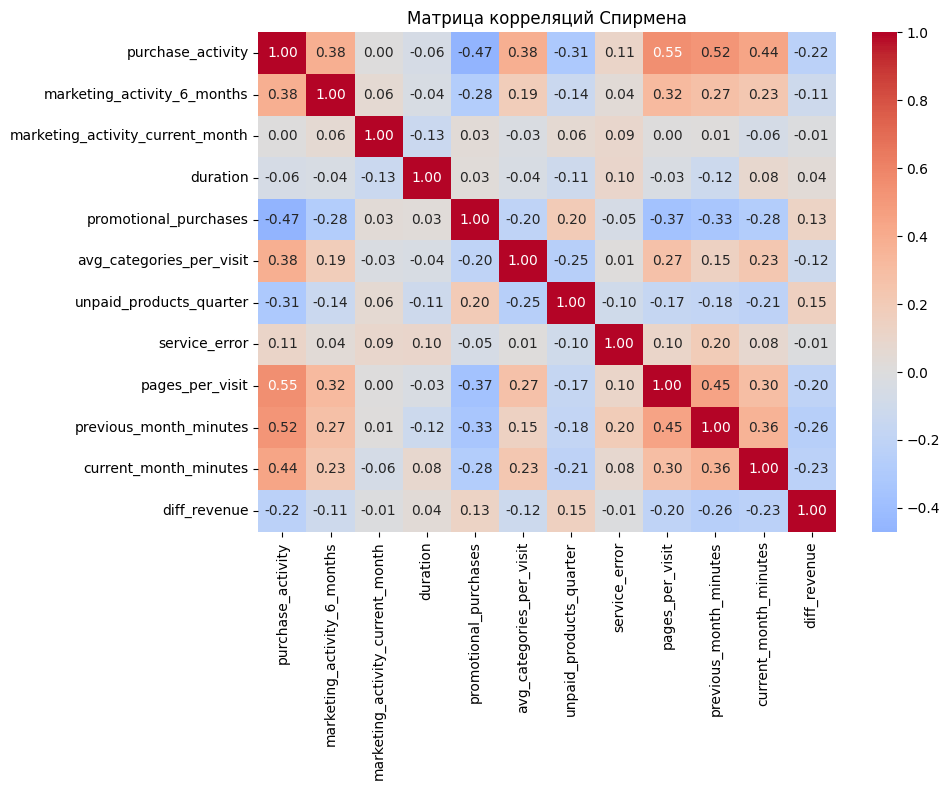

In [40]:
# Создаем копию и преобразуем целевой признак
df_analysis_train = modeling_df_train.copy()
df_analysis_train['purchase_activity'] = df_analysis_train['purchase_activity'].map({'снизилась': 0, 'прежний уровень': 1})

# Выделяем числовые признаки (без id)
numeric_df_train = df_analysis_train.select_dtypes(include=[np.number]).drop(columns=['id'])

# Корреляция Спирмена с целевым признаком
target_corr_spearman = numeric_df_train.corr(method='spearman')['purchase_activity'].sort_values(ascending=False)

print('КОРРЕЛЯЦИЯ СПИРМЕНА С ЦЕЛЕВЫМ ПРИЗНАКОМ:')
print('=' * 40)
for feature, corr in target_corr_spearman.items():
    print(f'{feature:30} : {corr:+.3f}')

# Визуализация матрицы корреляций Спирмена
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df_train.corr(method='spearman'), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций Спирмена')
plt.tight_layout()
plt.show()


<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---

<span style="color:cornflowerblue"> ВЫСОКИЕ КОРРЕЛЯЦИИ (0.4-0.6):

`purchase_activity` и `pages_per_visit`: 0.55

Самый сильный предиктор: чем больше страниц просматривает пользователь, тем выше вероятность сохранения активности.

`purchase_activity` и `previous_month_minutes`: 0.52

Время, проведенное на сайте в предыдущем месяце, является значимым индикатором текущей лояльности.

`purchase_activity` и `current_month_minutes`: 0.44
  
Текущая вовлеченность напрямую связана с сохранением покупательской активности.

`pages_per_visit` и `previous_month_minutes`: 0.45

Глубина изучения контента и продолжительность сессий очевидно взаимосвязаны.

<span style="color:cornflowerblue"> СИЛЬНЫЕ ОТРИЦАТЕЛЬНЫЕ СВЯЗИ:

`purchase_activity` и `promotional_purchases`: -0.47

Высокая доля покупок по акциям существенно снижает общую активность.

<span style="color:yellowgreen"> УМЕРЕННЫЕ КОРРЕЛЯЦИИ (0.2-0.3):






`purchase_activity` и `marketing_activity_6_months`: 0.38

Маркетинговая коммуникация в полугодовом периоде способствует удержанию клиентов.

`purchase_activity` и `avg_categories_per_visit`: 0.38

Широта покупательских интересов, выраженная в разнообразии просматриваемых категорий, снижает вероятность оттока.

<span style="color:yellowgreen"> УМЕРЕННЫЕ ОТРИЦАТЕЛЬНЫЕ СВЯЗИ:

- `purchase_activity` и `unpaid_products_quarter`: -0.31 

Наличие неоплаченных товаров заметно снижает покупательскую активность.

<span style="color:pink"> НЕЗНАЧИМЫЕ СВЯЗИ:

- `purchase_activity` и `service_error`: +0.11 

Технические сбои минимально влияют на активность пользователей.

- `purchase_activity` и `marketing_activity_current_month`: +0.003 

Текущие маркетинговые коммуникации практически не оказывают эффекта.

<span style="color:pink"> СЛАБЫЕ ОТРИЦАТЕЛЬНЫЕ СВЯЗИ:

- `purchase_activity` и `diff_revenue`: -0.22

Историческая разница в выручке слабо связана с текущей активностью.

- `purchase_activity` и `duration`: -0.06

"Возраст" аккаунта пользователя незначительно влияет на активность.

---

<span style="color:cornflowerblue"> ВЫСОКАЯ МУЛЬТИКОЛЛИНЕАРНОСТЬ:

Не обнаружена

---

<div style="border-left: 3px solid #6495ED; padding-left: 15px; margin: 15px 0;"> 
    
<span style="color:yellowgreen"> РЕЗЮМИРУЕМ 

1. Критическая мультиколлинеарность не обнаружена.
2. Корреляции Спирмена показывают более устойчивые монотонные зависимости.
3. Поведенческие метрики (просмотры страниц, время на сайте) - наиболее значимые предикторы.
4. Наибольшее негативное влияние на покупательскую активность оказывает зависимость от акционных покупок. Клиенты, ориентированные преимущественно на распродажи, демонстрируют значительно более более низкие (снижение на 47%) показатели удержания и регулярной активности.
</div>

## Шаг 6. Использование пайплайнов

In [41]:
# Выведем таблицудля моделирования
display(modeling_df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1296
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1296 non-null   int64  
 1   purchase_activity                 1296 non-null   object 
 2   service_type                      1296 non-null   object 
 3   allow_notifications               1296 non-null   object 
 4   marketing_activity_6_months       1296 non-null   float64
 5   marketing_activity_current_month  1296 non-null   int64  
 6   duration                          1296 non-null   int64  
 7   promotional_purchases             1296 non-null   float64
 8   popular_category                  1296 non-null   object 
 9   avg_categories_per_visit          1296 non-null   int64  
 10  unpaid_products_quarter           1296 non-null   int64  
 11  service_error                     1296 non-null   int64  
 12  pages_per_v

None

<div style="border-left: 3px solid #6495ED; padding-left: 15px; margin: 15px 0;">

---

Удаляем `id`

Целевой признак `purchase_activity`

Категориальные дискретные `remainder`:

- avg_categories_per_visit
- service_error
- marketing_activity_current_month
- unpaid_products_quarter

---

<span style="color:cornflowerblue"> Кодируем с помощью `OneHotEncoder`

- popular_category
- allow_notifications

<span style="color:cornflowerblue"> Кодируем с помощью `OrdinalEncoder`

- service_type 
  
<span style="color:cornflowerblue"> Масштабируем

- pages_per_visit 
- previous_month_minutes
- current_month_minutes
- marketing_activity_6_months
- duration
- diff_revenue
- promotional_purchases

In [42]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
                                                    modeling_df_train.drop(['id','purchase_activity'], axis=1),
                                                    modeling_df_train['purchase_activity'],
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE,
                                                    stratify = modeling_df_train['purchase_activity'])

print(f'Размерность X_train: {X_train.shape}')
print(f'Размерность y_train: {y_train.shape}')

print(f'Размерность X_test: {X_test.shape}')
print(f'Размерность y_test: {y_test.shape}')

Размерность X_train: (972, 14)
Размерность y_train: (972,)
Размерность X_test: (324, 14)
Размерность y_test: (324,)


In [43]:
# Подготовим Предсказательный датасет для предсказания целевого признака
modeling_df_predict = modeling_df_pred.drop(['id','purchase_activity'], axis=1)
modeling_df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1296
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   service_type                      1296 non-null   object 
 1   allow_notifications               1296 non-null   object 
 2   marketing_activity_6_months       1296 non-null   float64
 3   marketing_activity_current_month  1296 non-null   int64  
 4   duration                          1296 non-null   int64  
 5   promotional_purchases             1296 non-null   float64
 6   popular_category                  1296 non-null   object 
 7   avg_categories_per_visit          1296 non-null   int64  
 8   unpaid_products_quarter           1296 non-null   int64  
 9   service_error                     1296 non-null   int64  
 10  pages_per_visit                   1296 non-null   int64  
 11  previous_month_minutes            1296 non-null   int64  
 12  current_mon

In [44]:
# создаём списки с названиями признаков
ohe_columns = [
               'popular_category','allow_notifications'
                ]
ord_columns = [
                'service_type'
                ]
num_columns = [
                'pages_per_visit',
                'previous_month_minutes',
                'current_month_minutes',
                'marketing_activity_6_months',
                'diff_revenue',
                'duration',
                'promotional_purchases'
              ] 
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
                    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, 
                                                         strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', 
                                           handle_unknown='ignore' #, sparse=False
                                          ))
                    ]
                    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
                    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, 
                                                                strategy='most_frequent')),
                     ('ord',  OrdinalEncoder(
                                            categories=[
                                                           ['стандарт', 
                                                            'премиум']
                                                        ], 
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=np.nan
                                             )
                      ),
                     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, 
                                                               strategy='most_frequent'))
                     ]
                    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
                                        [('ohe', ohe_pipe, ohe_columns),
                                         ('ord', ord_pipe, ord_columns),
                                         ('num', MinMaxScaler(), num_columns)
                                         ], 
                                        remainder='passthrough'
                                      )

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
                        ('preprocessor', data_preprocessor),
                        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
                      ])

param_grid = [
                # словарь для модели DecisionTreeClassifier()
                {
                    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
                    'models__max_depth': range(2, 5),
                    'models__max_features': range(2, 5),
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
                },
                
                # словарь для модели KNeighborsClassifier() 
                #{
                #    'models': [KNeighborsClassifier()],
                #    'models__n_neighbors': range(2, 5),
                #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
                #},
            
                # словарь для модели LogisticRegression()
                #{
                #   'models': [LogisticRegression(
                #        random_state=RANDOM_STATE, 
                #        solver='liblinear', 
                #        penalty='l1'
                #    )],
                #    'models__C': range(1, 5),
                #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
                #},

                # словарь для модели SVC()
                {
                    'models': [SVC(random_state=RANDOM_STATE, probability=True)],
                    'models__C': [0.1, 1, 10],
                    'models__kernel': ['rbf', 'poly'], # убрали 'linear'
                    'models__gamma': ['scale', 'auto'],
                    'models__degree': [2, 3, 4],
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
                }  
            ]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

ERROR! Session/line number was not unique in database. History logging moved to new session 46
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['popular_category',
                                                   'allow_notifications']),
                                                 ('ord',
                                           

In [45]:
# Выведем реультаты
pd.set_option('display.max_colwidth', None) # Установим максимальную ширину столбцов на None, чтобы убрать ограничение

result = pd.DataFrame(randomized_search.cv_results_)
display(result[
                ['rank_test_score', 'param_models', 'mean_test_score','params']
              ].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
4,1,"SVC(probability=True, random_state=42)",0.901435,"{'preprocessor__num': RobustScaler(), 'models__kernel': 'rbf', 'models__gamma': 'auto', 'models__degree': 2, 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"
8,2,"SVC(probability=True, random_state=42)",0.896772,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models__gamma': 'scale', 'models__degree': 2, 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"
6,3,"SVC(probability=True, random_state=42)",0.894200,"{'preprocessor__num': RobustScaler(), 'models__kernel': 'poly', 'models__gamma': 'scale', 'models__degree': 2, 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"
1,4,"SVC(probability=True, random_state=42)",0.893376,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models__gamma': 'auto', 'models__degree': 3, 'models__C': 0.1, 'models': SVC(probability=True, random_state=42)}"
2,5,"SVC(probability=True, random_state=42)",0.892153,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models__gamma': 'scale', 'models__degree': 3, 'models__C': 10, 'models': SVC(probability=True, random_state=42)}"
3,6,"SVC(probability=True, random_state=42)",0.890079,"{'preprocessor__num': 'passthrough', 'models__kernel': 'linear', 'models__gamma': 'scale', 'models__degree': 4, 'models__C': 10, 'models': SVC(probability=True, random_state=42)}"
0,7,DecisionTreeClassifier(random_state=42),0.831277,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
5,8,DecisionTreeClassifier(random_state=42),0.824536,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
7,9,"SVC(probability=True, random_state=42)",0.571562,"{'preprocessor__num': 'passthrough', 'models__kernel': 'rbf', 'models__gamma': 'auto', 'models__degree': 4, 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"
9,9,"SVC(probability=True, random_state=42)",0.571562,"{'preprocessor__num': 'passthrough', 'models__kernel': 'rbf', 'models__gamma': 'auto', 'models__degree': 2, 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"


<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---

<span style="color:cornflowerblue"> ЛУЧШАЯ МОДЕЛЬ: <span style="color:black"> SVC

<span style="color:cornflowerblue"> ЛУЧШИЙ РЕЗУЛЬТАТ:  <span style="color:black"> ROC-AUC = 0.9014

<span style="color:cornflowerblue"> ПАРАМЕТРЫ ЛУЧШЕЙ МОДЕЛИ: 

- `RobustScaler`, 
- `Ядро` 'rbf', 
- `gamma` ='auto',
- `C`=1,
- `degree`=2

<span style="color:cornflowerblue"> Качество модели:

- Тренеровочная выборка ROC-AUC: 0.9014 (90.14%)
- Тестовая выборка ROC-AUC: 0.9093 (90.93%)

<div style="border-left: 3px solid #6495ED; padding-left: 15px; margin: 15px 0;">

---
Выбрали метрику ROC-AUC так как целевой признак бинарный, она устойчива к несбалансированным данным,работает с вероятностями, учитывает работу модели при всех возможных значениях порогов

## Шаг 7. Анализ важности признаков

In [46]:
data_preprocessor_final = ColumnTransformer(
                                        [('ohe', ohe_pipe, ohe_columns),
                                         ('ord', ord_pipe, ord_columns),
                                         ('num', RobustScaler(), num_columns)
                                         ], 
                                        remainder='passthrough'
                                      )

pipe_final_model = Pipeline([
                        ('preprocessor', data_preprocessor_final),
                        ('models', SVC(C=1, degree=2, kernel='rbf', gamma='auto', probability=True, random_state=42))
                      ])
pipe_final_model.fit(X_train, y_train)

X_train_p2 = pd.DataFrame(
                        data_preprocessor_final.fit_transform(X_train),
                        columns=data_preprocessor_final.get_feature_names_out()
                        )

X_test_p = pd.DataFrame(
                        data_preprocessor_final.fit_transform(X_test),
                        columns=data_preprocessor_final.get_feature_names_out()
                        )
modeling_df_predict_p = pd.DataFrame(
                        data_preprocessor_final.fit_transform(modeling_df_predict)
                        )

In [47]:
explainer = shap.SamplingExplainer(lambda x: pipe_final_model.named_steps['models'].predict_proba(x)[:,1], X_train_p2)
shap_values = explainer.shap_values(X_test_p)

  0%|          | 0/324 [00:00<?, ?it/s]

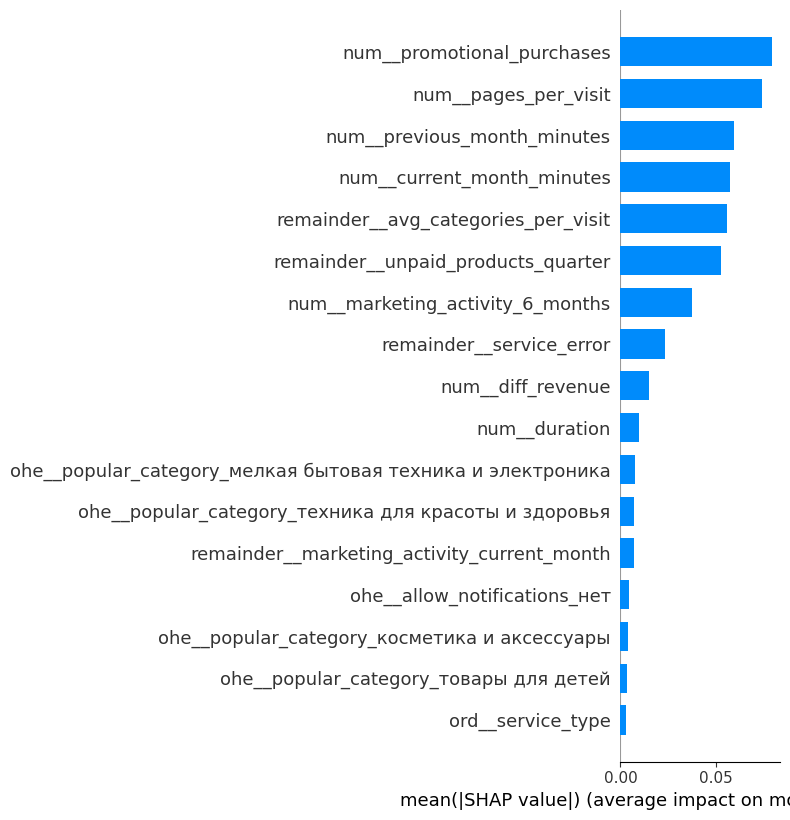

In [48]:
shap.summary_plot(shap_values, X_train_p2, plot_type='bar', max_display=17)

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

<span style="color:cornflowerblue"> ВАЖНОСТЬ ПРИЗНАКОВ МОДЕЛИ

<span style="color:crimson"> ТОП-6 [Сильнее всего влияют на целевой признак]

- `promotion_purchases` [Акционные покупки]
- `peges_per_visit` [Страниц за визит]
- `previous_month_minutes` [Предыдущий месяц минут]
- `current_month_minutes` [Текущей месяц минут]
- `avg_categories_per_visit` [Средний просмотр категорий за визит]
- `unpaid_products_quarter` [Неоплаченные продукты штук квартал]

<span style="color:crimson"> СРЕДНЯЯ ВАЖНОСТЬ:

- `marketing_activity_6_months` [Маркетинговая коммуникация за последние 6 месяцев]
- `service_error` [Ошибка сервиса]

<span style="color:crimson"> МАЛО ЗНАЧИМЫ:

- `diff_revenue` [Разница выручек]
- `duration` [Длительность в днях с момента регистрации]
- `popular_category` [Популярная категория: мелкая бытовая техника и электроника]
- `marketing_activity_current_month` [Маркетинговая активность в текущем месяце]
- `popular_category` [Популярная категория: техника для красоты и здоровья]
- `allow_notifications_нет` [НЕ разрешать сообщать]
- `popular_category_` [Популярная категория: косметика и аксессуары]
- `popular_category_` [Популярная категория: кухонная посуда]
- `popular_category_` [Популярная категория: товары для детей]
- `service_type` [Тип сервиса]

<span style="color:cornflowerblue"> ИСПОЛЬЗУЕМ ЭТИ НАБЛЮДЕНИЯ:

<span style="color:cornflowerblue"> **При моделировании**

- Собирать больше поведенческих метрик на сайте так как топ важности признаков связан с вовлеченностью
      
<span style="color:cornflowerblue"> **При принятии бизнес-решений**


`Продукт`:

- Оптимизировать навигацию сайта для роста `pages_per_visit` и `avg_categories_per_visit`;
- Улучшить UX для увеличения времени на сайте `[_minutes]`;
- Упростить процесс оплаты `[борьба с unpaid_products]`;
- Инвестировать в стабильность сервиса `[борьба с service_error]`.

`Клиентский опыт`:

- Персонализированные товары (сопутствующие) купленным продуктам;
- Персонализировать коммуникации на основе `popular_category`;
- Оптимизировать частоту уведомлений `[разрешение слабо влияет]`.

---

<span style="color:cornflowerblue"> **Приоритеты развития:**

- Удобство навигации;
- Время вовлечения;
- Акционные механики;
- Упрощение покупки.

<div style="border-left: 3px solid #6495ED; padding-left: 15px; margin: 15px 0;">

Т.е. фокус на поведенческих факторах.

## Шаг 8. Предсказание целевого признака

---

**Мы построили модель, которая может предсказывать вероятность покупательской активности в следующие три месяца.**

- Принимаем, что рассматриваемый трёхмесячный период включает в себя **предпредыдущий**, **предыдущий** и **текущий** месяц.
- Соответственно, следующий трёхмесячный период принимаем как **предыдущий**, **текущий** и **следующий** месяц. 

Так как (по заданию) прибыль на **следующий** месяц мы не прогнозируем, то определяем уровень активности для **следующего** месяца таким образом: 

- Сейчас у нас есть информация о трёх месяцях (**текущем** и **двух предыдущих** месяцах),
- соответственно мы считаем, что **текущий** уровень пользовательской активности определяется данными по **предыдущему** и **предпредыдущему** месяцам,
-  поэтому уровень пользовательской активности в **следующем** месяце будет определяться данными по **текущему** и **предыдущему** месяцам.

---

In [49]:
# Предсказываем целевой признак
y_pred = pipe_final_model.named_steps['models'].predict(modeling_df_predict_p)
# Добавляем предсказанные значения в датасет с будущим датасетом для сегментации
modeling_df_predict['purchase_activity_predict'] = y_pred
# Добавляем id для присоединения среднемесячной прибыли
modeling_df_predict['id'] = modeling_df_pred['id']
# Добавляем текущую пользовательскую активность
modeling_df_predict['purchase_activity_current'] = modeling_df_train['purchase_activity']

# Объединяем с основной таблицей
modeling_df_predict = modeling_df_predict.merge(money, on='id', how='inner')

# Делаем столбец id первым
cols = modeling_df_predict.columns.tolist()
cols = ['id'] + [col for col in cols if col != 'id']
modeling_df_predict = modeling_df_predict[cols]

# Выводим таблицу
head_and_info_display(modeling_df_predict)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 1296 строк, 18 столбцов

Первые 5 строк:
---------------


,id,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,avg_categories_per_visit,unpaid_products_quarter,service_error,pages_per_visit,previous_month_minutes,current_month_minutes,diff_revenue,purchase_activity_predict,purchase_activity_current,profit
0,215349,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,12,10,-244.4,снизилась,снизилась,4.16
1,215350,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,8,13,-399.1,прежний уровень,снизилась,3.13
2,215351,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,11,13,452.4,прежний уровень,снизилась,4.87
3,215352,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,8,11,65.0,снизилась,снизилась,4.21
4,215353,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,10,10,650.0,снизилась,снизилась,3.95



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1296 non-null   int64  
 1   service_type                      1296 non-null   object 
 2   allow_notifications               1296 non-null   object 
 3   marketing_activity_6_months       1296 non-null   float64
 4   marketing_activity_current_month  1296 non-null   int64  
 5   duration                          1296 non-null   int64  
 6   promotional_purchases             1296 non-null   float64
 7   popular_category                  1296 non-null   object 
 8   avg_categories_per_visit          1296 non-null   int64  
 9   unpaid_products_quarter           1296 non-null   int64  
 10  service_error                     1296 non-null   int64  
 11  pages_per_visit                 

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---

Мы предположили, что покупательская активность в наступающем месяце является продолжением тенденций, наблюдаемых в текущем и предыдущем месяцах. Таким образом, используя самые свежие данные, мы экстраполировали уровень активности на ближайшее будущее:

- Получили прогнозные значения пользовательской активности и добавили предсказанные значения `purchase_activity_predict` в датасет для сегментации;
- Добавили `id` для присоединения среднемесячной прибыли;
- Добавили `profit` (данные о прибыли).
- Добавили `purchase_activity_current` для выявления теплого сегмента с предсказанным снижением пользовательской активности

---

## Шаг 9. Сегментация покупателей

In [50]:
# Выведем сегмет пользователей с признаками снижения вовлеченности
segment = modeling_df_predict[(modeling_df_predict['purchase_activity_current'] == 'прежний уровень') &
    (modeling_df_predict['purchase_activity_predict'] == 'снизилась')]
# Выводим таблицу
head_and_info_display(segment)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 23 строк, 18 столбцов

Первые 5 строк:
---------------


,id,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,avg_categories_per_visit,unpaid_products_quarter,service_error,pages_per_visit,previous_month_minutes,current_month_minutes,diff_revenue,purchase_activity_predict,purchase_activity_current,profit
840,216192,стандарт,да,3.3,3,641,0.27,косметика и аксесcуары,4,1,1,9,11,9,856.7,снизилась,прежний уровень,4.01
969,216321,стандарт,нет,4.3,5,544,0.23,техника для красоты и здоровья,2,3,4,10,10,9,1170.0,снизилась,прежний уровень,3.95
979,216331,стандарт,да,4.2,4,470,0.23,кухонная посуда,1,4,4,9,13,14,1266.2,снизилась,прежний уровень,2.16
1004,216356,стандарт,да,5.5,4,1022,0.91,мелкая бытовая техника и электроника,3,0,3,11,13,6,529.1,снизилась,прежний уровень,3.26
1031,216383,стандарт,да,4.3,5,748,0.95,косметика и аксесcуары,3,1,6,6,19,7,310.7,снизилась,прежний уровень,4.65



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 840 to 1295
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                23 non-null     int64  
 1   service_type                      23 non-null     object 
 2   allow_notifications               23 non-null     object 
 3   marketing_activity_6_months       23 non-null     float64
 4   marketing_activity_current_month  23 non-null     int64  
 5   duration                          23 non-null     int64  
 6   promotional_purchases             23 non-null     float64
 7   popular_category                  23 non-null     object 
 8   avg_categories_per_visit          23 non-null     int64  
 9   unpaid_products_quarter           23 non-null     int64  
 10  service_error                     23 non-null     int64  
 11  pages_per_visit                   23 

In [51]:
print(f'Размер целевого сегмента: {len(segment)} клиентов')
print(f'Доля от общей базы: {len(segment)/len(modeling_df_predict)*100:.1f}%')

Размер целевого сегмента: 23 клиентов
Доля от общей базы: 1.8%


In [52]:
def plot_multiple_scatter_trends_with(df, quant_columns=None, categ_columns=None, target_column='profit', figsize=(15, 10)):
    """
    Строит диаграммы рассеяния с линиями тренда: прибыль vs количественные признаки
    с окраской по категориальным признакам
    
    Параметры:
    df - DataFrame с данными
    quant_columns - Список количественных признаков для оси X
    categ_columns - Список категориальных признаков для окраски
    target_column - Целевой признак (по умолчанию 'profit')
    figsize - Размер общего графика
    """
    
    # Количественные признаки по умолчанию
    if quant_columns is None:
        quant_columns = [
            #'duration',  # Длительность
            'marketing_activity_6_months',  # Маркетинговая активность за 6 месяцев
            'marketing_activity_current_month',  # Маркетинговая активность текущий месяц
            'promotional_purchases',  # Акционные покупки
            'avg_categories_per_visit',  # Среднее количество категорий за визит
            'unpaid_products_quarter',  # Неоплаченные продукты за квартал
            #'service_error',  # Ошибки сервиса
            'pages_per_visit',  # Страниц за визит
            'previous_month_minutes',  # Минуты в предыдущем месяце
            'current_month_minutes',  # Минуты в текущем месяце
           # 'diff_revenue'  # Разница в выручке
        ]
    
    # Категориальные признаки по умолчанию
    if categ_columns is None:
        categ_columns = [
            #'service_type',  # Тип сервиса
           #'allow_notifications',  # Разрешение уведомлений
            #'popular_category',  # Популярная категория
            #'purchase_activity_current',  # Текущая активность покупок
            'purchase_activity_predict'  # Предсказанная активность покупок
        ]
    
    # Создаем сетку графиков
    n_plots = len(quant_columns)
    n_cols = 2
    n_rows = (n_plots + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Преобразуем axes в плоский список для удобства
    if hasattr(axes, 'flatten'):
        axes = axes.flatten()
    elif n_cols == 1:
        axes = [axes]
    
    # Строим графики для каждого количественного признака
    for i, quant_column in enumerate(quant_columns):
        if i >= len(axes):
            break
        
        ax = axes[i]
        
        # Вычисляем корреляцию между количественным признаком и прибылью
        correlation = df[[quant_column, target_column]].corr(method='spearman').iloc[0, 1]
        
        # Рисуем scatter plot с окраской по первому категориальному признаку
        # (можно изменить на любой другой из categ_columns)
        color_by = categ_columns[0]  # Окрашиваем по первому категориальному признаку
        
        sns.scatterplot(data=df, 
                       x=quant_column, 
                       y=target_column,  # Прибыль по оси Y
                       hue=color_by,
                       alpha=0.7,
                       palette='Set2', 
                       ax=ax, 
                       s=60)
        
        # Линия тренда для общей зависимости
        if len(df) > 1:
            # Убираем пропуски
            trend_data = df[[quant_column, target_column]].dropna()
            if len(trend_data) > 1:
                slope, intercept = np.polyfit(trend_data[quant_column], trend_data[target_column], 1)
                x_range = np.linspace(df[quant_column].min(), df[quant_column].max(), 100)
                y_trend = slope * x_range + intercept
                ax.plot(x_range, y_trend, 'r--', linewidth=2, alpha=0.8, label='Тренд')
        
        # Оформляем график
        ax.set_title(f'Прибыль vs {quant_column}\nCorr: {correlation:.3f}', fontsize=12, fontweight='bold')
        ax.set_xlabel(quant_column)
        ax.set_ylabel('Прибыль (profit)')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Скрываем пустые графики
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

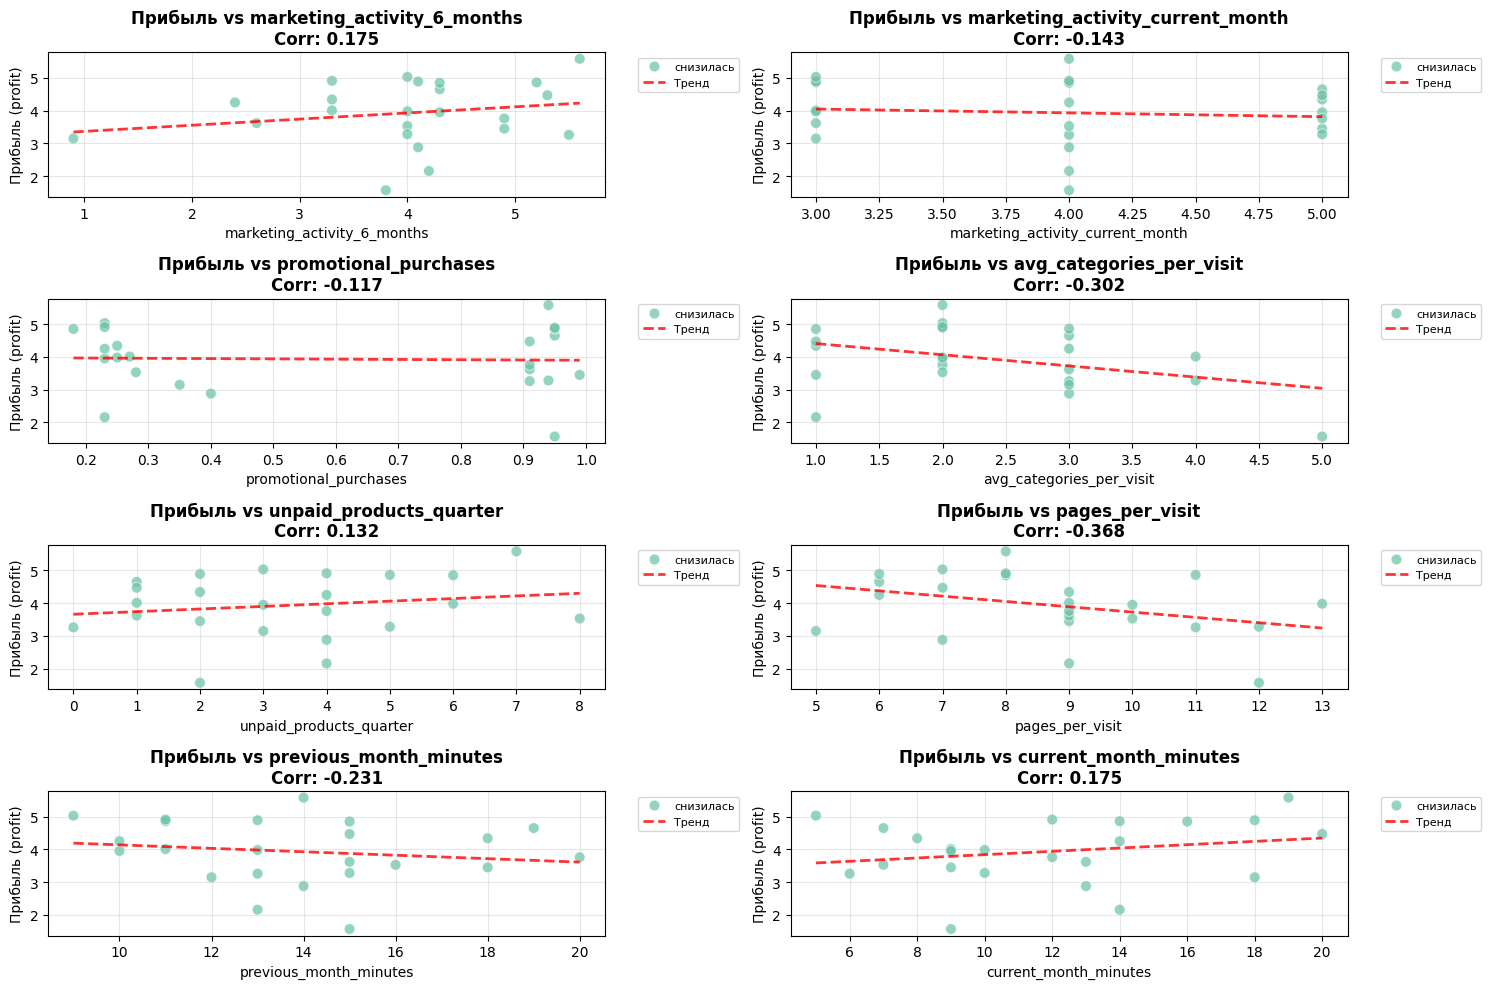

In [53]:
plot_multiple_scatter_trends_with(segment)

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---

<span style="color:cornflowerblue"> ЗАВИСИМОСТЬ ПРИБЫЛИ ОТ ЗНАЧИМЫХ ПРИЗНАКОВ У КЛИЕНТОВ, ПОКАЗЫВАЮЩИХ СНИЖЕНИЕ ПОЛЬЗОВАТЕЛЬСКОЙ АКТИВНОСТИ 

- `Прибыль` и `marketing_activity_6_months` # Маркетинговая активность за 6 месяцев

Большую прибыль приносят клиенты, у которых больше кол-во маркетинговых коммуникаций за последние 6 месяцев.

- `Прибыль` и `marketing_activity_current_month`  # Маркетинговая активность текущий месяц

В текущем месяце чем больше маркетинговой коммуникациии, тем меньше прибыль. Возможно была коммуникация, которая отрицательно повлияла на прибыль 

- `Прибыль` и `promotional_purchases`  # Акционные покупки

По графуку видно, что определенная доля клиентов, показавших снижение активности покупает только товары по акции. А остальная часть наоборот. Т.е. нет группы со средней долей, что может говорить о необходимости пересмотра акционных программ/акционной политики.

- `Прибыль` и `avg_categories_per_visit` # Среднее количество категорий за визит

Те клиенты, которые смотрят в среднем 1 и 2 категории за визит приносят больше прибыли(люди зашли с конкретной целью, например акции) чем те, которые смотря 3 и больше категорий за визит(люди, возможно больше вовлечены и покупают вдолгую). Необходимы персонализированные акции и рекомендательная система.

- `Прибыль` и `unpaid_products_quarter`  # Неоплаченные продукты за квартал

От клиентов, которые добавляют больше продуктов в корзину, прибыль больше. Это вовлеченные люди, которые пользовались сайтом активно, но почему-то стали пользоваться реже. Это или изменение ценовой политики, или изменение каких-то внешних факторов, которые повлияли на их покупательную способность. Возможно, они ждали скидки на определенные виды, категории товаров.

- `Прибыль` и  `pages_per_visit`  # Страниц за визит

В этой группе клиентов нет корреляции прибыли с количеством просмотренных страниц за визит

- `Прибыль` и  `previous_month_minutes` / `current_month_minutes` # Минуты в предыдущем и техущем месяце

В предыдущем месяце время, проведенное на сайте приводило к уменьшению прибыли, а в текущем - наоборот. Что может говорить о негативной вовлеченности (пользователь что-то искал, но не находил).

---

- В течение 6 месяцев маркетинговая коммуникация давала положительый эффект, а в прошлый - нет.
- Часть пользователей, которые или покупают только по акциям, или не пользуются ими вообще, что говорит о неудачной проведенной акционной компании.
- Люди или приходят точно за чем-то конкретным или пытаются найти ряд интересующих их товаров из различных категорий, но или не находят и прекращают поиск, или находят спустя множество попыток, что тоже говорит о некой негативной вовлеченности.
- От клиентов, которые добавляют больше продуктов в корзину, прибыль больше (это вовлеченные люди, которые пользовались сайтом активно, но почему-то стали пользоваться реже). Это или изменение ценовой политики, или изменение каких-то внешних факторов, которые повлияли на их покупательную способность. Возможно, они ждали скидки на определенные виды, категории товаров.
- Раньше большее время, проведенное на сайте отрицательно влияло на прибыль, а в текущем месяце -  положительно.

<div style="border-left: 3px solid #6495ED; padding-left: 15px; margin: 15px 0;">

Скорее всего была агрессивная рекламная компания, которая информировала пользователей об акционном снижении цен. Это привело к росту вовлеченности, но сама вовлеченность к росту прибыли не привела, что говорит о неосоответствии ожиданий пользователей и предложениями сайта. Не продуманная маркетинговая стратегия, в которой ценновая политика расходится с рекламной, что приводит к негативной вовлеченности и оттоку дезинформированных клиентов.

<span style="color:cornflowerblue"> ПРЕДЛОЖЕНИЕ

- Снижение репутации произошло. Решение: Организовать персонализированные предложения, чтобы повысить лояльность.


## Общий вывод

<div style="background-color: white; border: 3px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:cornflowerblue"> Шаг 1: ИЗУЧЕНИЕ ДАННЫХ

- Приведены названия столбцов к единому стилю `(англоязычные, snake_case)`.
- Устранены неявные дубликаты и опечатки `(например, «стандартт» → «стандарт», «предыдцщий_месяц» → «предыдущий_месяц»)`.
- Исправлены данные: регистр в текстовых полях, разделитель дробей (запятая → точка), орфография.
- Приведены типы данных: `profit` изменён на `float`.
- Подтверждено отсутствие пропусков. Явных дубликатов не найдено.

**Результат**: Данные приведены к чистому, согласованному формату, готовы к анализу.

<span style="color:cornflowerblue"> Шаг 2: ПРЕДОРАБОТКА ДАННЫХ

- Проведена проверка на дубликаты — явные отсутствуют.
- Все таблицы проверены и очищены от некорректных значений.
- Приведены данные к единообразию: нижний регистр, единый формат периодов.
- Тип данных profit исправлен на числовой.

**Результат**: Данные корректны, структурированы, пригодны для дальнейшего анализа.

<span style="color:cornflowerblue"> Шаг 3: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

**Категориальные признаки:**

- Покупательская активность: `61.7% — стабильные, 38.3% — снижаются → нужна работа по удержанию.`
- Тип сервиса: `71.1% — стандарт, 29% — премиум → потенциал монетизации.`
- Разрешение уведомлений: `74% согласны → высокая лояльность к коммуникациям.`
- Популярная категория: `лидер — детские товары (25.4%), низкий интерес к посуде (10.6%) → повод пересмотреть ассортимент.`
- Маркетинг в текущем месяце: `51.5% — 4 контакта → умеренная активность, но сегментированная.`
- Неоплаченные товары: `1–4 товара в корзине у большинства → проблема конверсии.`
- Ошибки сервиса: `47% столкнулись с 3–5 сбоями → системные проблемы стабильности.`

**Количественные признаки:**

- Маркетинг за 6 месяцев, длительность, страниц за визит, минуты, выручка, прибыль — распределения близки к нормальному.
- Акционные покупки — асимметричное распределение: есть сегмент «охотников за скидками».
- Время на сайте — в среднем 13 минут → достаточное для вовлечённости.

**Результат**: Выявлены ключевые паттерны поведения, аномалии и потенциальные точки роста.

<span style="color:cornflowerblue"> Шаг 4: ОБЪЕДИНЕНИЕ ДАННЫХ иИ ФОРМИРОВАНИЕ ВЫБОРОК

- Объединены таблицы `market_file`, `market_money`, `market_time` → `modeling_df` (1296 строк, 18 столбцов).
- Удалён пользователь с аномальной выручкой `(ID: 215380)` и пропуском.

Созданы два датасета:

- `modeling_df_train` — для обучения модели.
- `modeling_df_pred` — для прогнозирования.
- Введён дополнительный признак `diff_revenue` (разница в выручке).

**Результат**: Сформированы обучающая и предсказательная выборки для моделирования.

<span style="color:cornflowerblue"> Шаг 5: КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

`Сильные положительные связи:`

- pages_per_visit (0.55) и previous_month_minutes (0.52) — ключевые предикторы активности.

`Сильная отрицательная связь:`

- promotional_purchases (–0.47) — зависимость от скидок снижает активность.

`Умеренные связи:`

- marketing_activity_6_months и avg_categories_per_visit — способствуют удержанию.

`Незначимые факторы:`

- marketing_activity_current_month (+0.003) — текущие рассылки не работают.
- duration (–0.06) — «возраст» аккаунта почти не влияет.

`Мультиколлинеарность` не выявлена.

**Результат**: Поведенческие метрики — главные драйверы активности. Акции и текущие рассылки — слабые инструменты.

<span style="color:cornflowerblue"> Шаг 6: ПОСТРОЕНИЕ И ВЫБОР МОДЕЛИ

`Лучшая модель`: SVC

`Лучший результат`: ROC-AUC = 0.9014

`Параметры лучшей модели`:

- RobustScaler,
- Ядро 'rbf',
- gamma='auto',
- C=1,
- degree=2

`Качество модели`:

- Тренеровочная выборка ROC-AUC: 0.9014 (90.14%)
- Тестовая выборка ROC-AUC: 0.9093 (90.93%)

Метрика выбрана за устойчивость к дисбалансу и работу с вероятностями.

**Результат:** Модель высокоточная, обобщает данные хорошо, готова к предсказанию.

<span style="color:cornflowerblue"> Шаг 7: ВАЖНОСТЬ ПРИЗНАКОВ

<span style="color:crimson"> ТОП-6 [Сильнее всего влияют на целевой признак]

- `promotion_purchases` [Акционные покупки]
- `peges_per_visit` [Страниц за визит]
- `previous_month_minutes` [Предыдущий месяц минут]
- `current_month_minutes` [Текущей месяц минут]
- `avg_categories_per_visit` [Средний просмотр категорий за визит]
- `unpaid_products_quarter` [Неоплаченные продукты штук квартал]

<span style="color:crimson"> СРЕДНЯЯ ВАЖНОСТЬ:

- `marketing_activity_6_months` [Маркетинговая коммуникация за последние 6 месяцев]
- `service_error` [Ошибка сервиса]

<span style="color:crimson"> МАЛО ЗНАЧИМЫ:

- `diff_revenue` [Разница выручек]
- `duration` [Длительность в днях с момента регистрации]
- `popular_category` [Популярная категория: мелкая бытовая техника и электроника]
- `marketing_activity_current_month` [Маркетинговая активность в текущем месяце]
- `popular_category` [Популярная категория: техника для красоты и здоровья]
- `allow_notifications_нет` [НЕ разрешать сообщать]
- `popular_category_` [Популярная категория: косметика и аксессуары]
- `popular_category_` [Популярная категория: кухонная посуда]
- `popular_category_` [Популярная категория: товары для детей]
- `service_type` [Тип сервиса]

  
`РЕКОМЕНДАЦИИ`

- Фокус на вовлечённости и поведенческих метриках( так как топ важности признаков связан с вовлеченностью).
- Оптимизировать UX: навигацию, процесс оплаты, время на сайте.
- Пересмотреть акционные механики и частоту уведомлений.

<span style="color:cornflowerblue"> Шаг 8: ПРОГНОЗИРОВАНИЕ ПОЛЬЗОВАТЕЛЬСКОЙ АКТИВНОСТИ

- На основе модели предсказаны значения `purchase_activity_predic`t.
- Добавлены `profit` и `purchase_activity_current` для сегментации.
- Выделен «тёплый» сегмент — пользователи с текущей активностью, но прогнозируемым снижением.

**Результат:** Готова база для таргетированной работы с клиентами перед оттоком.

<span style="color:cornflowerblue"> Шаг 9: СЕГМЕНТАЦИЯ И БИЗНЕС-ВЫВОДЫ

- В течение 6 месяцев маркетинговая коммуникация давала положительый эффект, а в прошлый - нет.
- Часть пользователей, которые или покупают только по акциям, или не пользуются ими вообще, что говорит о неудачной проведенной акционной компании.
- Люди или приходят точно за чем-то конкретным или пытаются найти ряд интересующих их товаров из различных категорий, но или не находят и прекращают поиск, или находят спустя множество попыток, что тоже говорит о некой негативной вовлеченности.
- От клиентов, которые добавляют больше продуктов в корзину, прибыль больше (это вовлеченные люди, которые пользовались сайтом активно, но почему-то стали пользоваться реже). Это или изменение ценовой политики, или изменение каких-то внешних факторов, которые повлияли на их покупательную способность. Возможно, они ждали скидки на определенные виды, категории товаров.
- Раньше большее время, проведенное на сайте положительно влияло на прибыль, а в текущем месяце -  отрицательно.

<div style="border-left: 3px solid #6495ED; padding-left: 15px; margin: 15px 0;">

Скорее всего была агрессивная рекламная компания, которая информировала пользователей об акционном снижении цен. Это привело к росту вовлеченности, но сама вовлеченность к росту прибыли не привела, что говорит о неосоответствии ожиданий пользователей и предложениями сайта. Не продуманная маркетинговая стратегия, в которой ценновая политика расходится с рекламной, что приводит к негативной вовлеченности и оттоку дезинформированных клиентов.

<span style="color:cornflowerblue"> ПРЕДЛОЖЕНИЕ

- Снижение репутации произошло. Решение: Организовать персонализированные предложения, чтобы повысить лояльность.
